# Hitori

## Prezentacja problemu

Hitori to logiczna łamigłówka, która polega na zaczernieniu powtarzających się cyfr występujących w wierszach lub kolumnach tak, aby każda z nich występowała w wierszu lub kolumnie co najwyżej jeden raz. Zaczernione pola nie mogą być połączone bokami, a jasne pola muszą utworzyć poliomino, czyli spójny wielokąt utworzony z białych pól.

Hitori jest NP-zupełne.

Zasady:
1) Pokoloruj komórki tak, by żadna liczba nie pojawiała się więcej niż raz w rzędzie lub kolumnie.
2) Boki czarnych komórek nigdy się nie stykają.
3) Białe komórki tworzą ciągłą sieć (poliomino).

## Pierwszy sposób rozwiązania zadania

In [1]:
# Pierwsze podejście do problemu:

# kodujemy łamigłówkę jako macierz mxm
# rozwiązaniem będzie lista z informacją, które komórki należy zamalować na czarno
# geny to liczby: 0 - kolorujemy na czarno, 1 - zostawiamy liczbę tak jak jest
# chromosom będzie miał m*m genów
# funkcja fitness będzie nakładać kary za złamanie warunków łamigłówki i dawać nagrody za ich spełnienie
# rozwiązanie o największej wartości fitness jest najlepsze

In [2]:
import time
import math
import pygad
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## 5x5

In [3]:
# Dla różnych rozmiarów inputów szkielet funkcji fitness jest taki sam,
# jednak należy zmienić zakresy niektórych pętli czy liczbę liczników,
# oraz dostosować odpowiednio wartości nakładanych kar czy nagród.
# Dlatego przy każdej zmianie rozmiaru łamigłówki funkcja fitness jest definiowana jeszcze raz.

In [4]:
# definiujemy parametry rozwiązania
# 1 - zostawiamy liczbę, 0 - kolorujemy na czarno
gene_space = [0, 1]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    
    # warunek, że czarne pola nie mogą stykać się bokami
    for m in [0, 5, 10, 15, 20]:
        for n in range(4):
            # sprawdzamy wiersze, jeśli na prawo od zera też jest zero, to nakładamy karę
            if int(solution[m+n]) == 0:
                if int(solution[m+n+1]) == 0:
                    wynik -= 1
    for m in [0, 5, 10, 15]:
        for n in range(5):
            # sprawdzamy kolumny, jeśli pod zerem też jest zero, to nakładamy karę
            if int(solution[m+n]) == 0:
                if int(solution[m+n+5]) == 0:
                    wynik -= 1
    
    tablica1 = [[0 for _ in range(5)] for _ in range(5)]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(5):
        tablica1[0][i] = int(tablica[0][i]*solution[i])
        tablica1[1][i] = int(tablica[1][i]*solution[i+5])
        tablica1[2][i] = int(tablica[2][i]*solution[i+10])
        tablica1[3][i] = int(tablica[3][i]*solution[i+15])
        tablica1[4][i] = int(tablica[4][i]*solution[i+20])
    
    # w kolumnie lub wierszu liczby od 1 do 5 nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna liczba od 1 do 5, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        for j in kolumna: # jeśli liczby się powtarzają, to zwiększamy licznik
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
        for k in [count1, count2, count3, count4, count5]:
            if k > 1: # im więcej takich samych liczb tym większa kara
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        # jeśli we wierszu występuje więcej niż jedna liczba od 1 do 5, to nakładamy karę
        for j in tablica1[i]: # jeśli liczby się powtarzają, to zwiększamy licznik
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
        for k in [count1, count2, count3, count4, count5]:
            if k > 1: # im więcej takich samych liczb tym większa kara
                wynik -= 2*k
    
    # warunek, że białe pola (jedynki) nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(5)] for _ in range(5)]
    for i in range(5):
        tablica2[0][i] = tablica2[0][i]*solution[i]
        tablica2[1][i] = tablica2[1][i]*solution[i+5]
        tablica2[2][i] = tablica2[2][i]*solution[i+10]
        tablica2[3][i] = tablica2[3][i]*solution[i+15]
        tablica2[4][i] = tablica2[4][i]*solution[i+20]
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej jedynki
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    komorka = [[i, j]]
    # w pęlti przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    # do momentu, gdy nie znajdziemy już żadnej nieodwiedzonej jedynki, która jest połączona bokiem z inną jedynką
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            # czy nowe współrzędne nie przekraczają długości tablicy
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                # jeśli nie odwiedziliśmy jeszcze danej jedynki to dodajemy ją do listy
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])
    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 2 # dajemy odpowiednią nagrodę (dla większych inputów 2 punkty nie będą opłacalne, będziemy musieli dać więcej)
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 2 # nakładamy karę za nie spełnienie warunku łamigłówki
    # wiemy, że rozwiązanie ma 7 zamalowanych komórek, więc nagradzamy za to (próbujemy nakierować algorytm na rozwiązanie)
    if np.count_nonzero(solution == 0) == 7:
        wynik += 2
    return wynik

fitness_function = fitness_func

In [5]:
# Chociaż funkcja rozwiązuje też małe inputy dla mniejszych populacji czy mniejszej ilości pokoleń,
# parametry sol_per_pop, num_parents_mating, num_generations są takie same dla wszystkich inputów,
# by można było porównać jej efektywność dla różnych rozmiarów łamigłówek.
# Wartości tych parametrów są dobrane tak, by czasy rozwiązywania dużych inputów nie były zbyt długie
# (przyjmując, że duże łamigłówki rozwiązywane są w 10 sekund, powtórzenie tego działania 100 razy
# podczas testowania efektywności, daje nam prawie 17 minut czekania na wynik).

In [6]:
# ile chromosomów w populacji
sol_per_pop = 1000 #600
# ile genów ma chromosom
num_genes = 25 # tyle mamy pól, solution ma 25 genów

# ile wylaniamy rodziców do "rozmnażania" (okolo 50% populacji)
num_parents_mating = 500 #300
# ile pokoleń
num_generations = 60 #50
# ilu rodziców zachować (kilka procent)
keep_parents = 2

# jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "rank" # wydaje się być efektywniejsza niż sss

# w ilu punktach robic krzyzowanie?
#single_point, two_points, uniform, scattered
crossover_type = "single_point"

# mutacja ma dzialac na ilu procent genów?
#random, swap - zamienia miejscami dwa geny, inversion - zmienia kolejność fragmentu chromosomu, scramble, adaptive
#displacament - przeniesienie części genów w inne miejsce
mutation_type = "inversion" # wiemy ile zer ma mieć rozwązanie, taka mutacja nie zmienia ilości zer i jedynek
mutation_percent_genes = 5 # 25*0.05 czyli 1 gen sie zmieni

### 1)

In [7]:
r1 = [2, 1, 1, 5, 5]
r2 = [4, 2, 5, 1, 3]
r3 = [2, 5, 3, 4, 3]
r4 = [3, 1, 3, 5, 4]
r5 = [1, 3, 4, 4, 1]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0, # pozbywamy się elityzmu, zachowując rodziców funkcja utykała w maksimum lokalnym
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_4'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  7.265231370925903
Number of generations passed is : 60
Parameters of the best solution : [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1.]
Fitness value of the best solution = 3


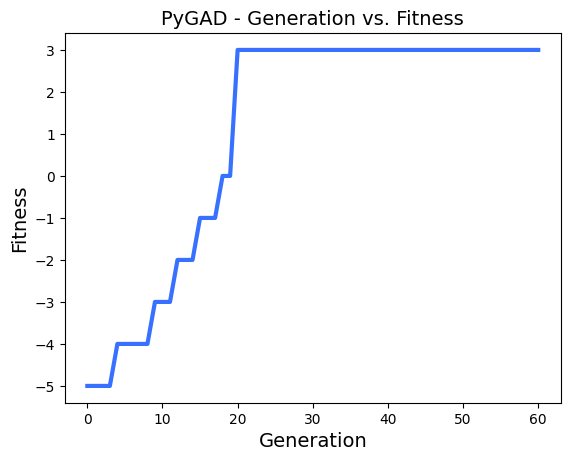

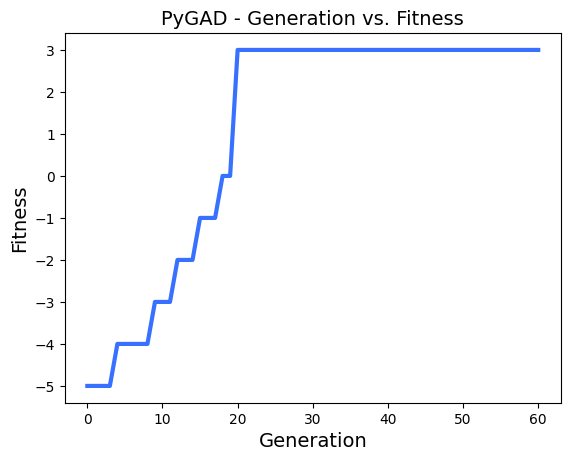

In [8]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [9]:
# najlepsze wyłonione rozwiązanie
r1 = [2, 1, 1, 5, 5]
r2 = [4, 2, 5, 1, 3]
r3 = [2, 5, 3, 4, 3]
r4 = [3, 1, 3, 5, 4]
r5 = [1, 3, 4, 4, 1]
tablica4 = [r1, r2, r3, r4, r5]
for i in range(5):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+5])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+10])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+15])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+20])
tablica4

[[0, 0, 1, 0, 5],
 [4, 2, 5, 1, 3],
 [2, 5, 3, 4, 0],
 [3, 1, 0, 5, 4],
 [0, 3, 4, 0, 1]]

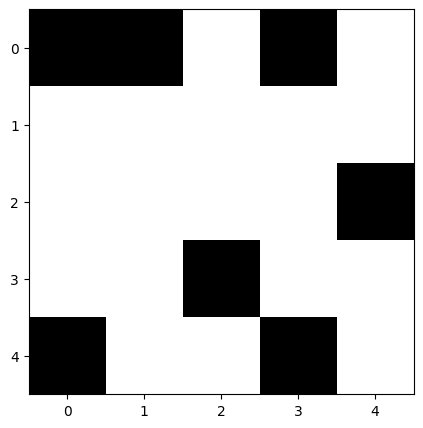

In [10]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

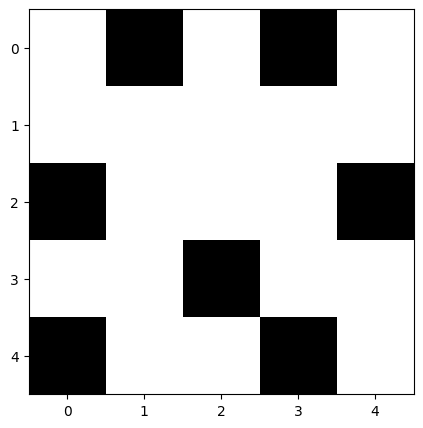

In [11]:
# wykres prawidłowego rozwiązania
rozwiazanie = [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [12]:
r1 = [2, 2, 5, 1, 5]
r2 = [2, 3, 1, 5, 5]
r3 = [4, 4, 3, 5, 2]
r4 = [4, 5, 4, 3, 3]
r5 = [5, 4, 5, 3, 1]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_4'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  1.6716856956481934
Number of generations passed is : 18
Parameters of the best solution : [0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1.]
Fitness value of the best solution = 4


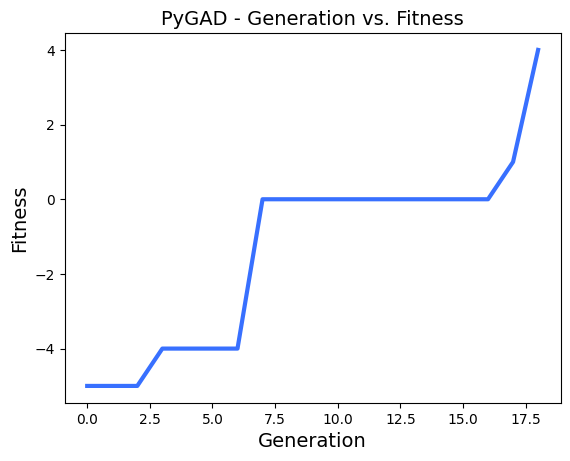

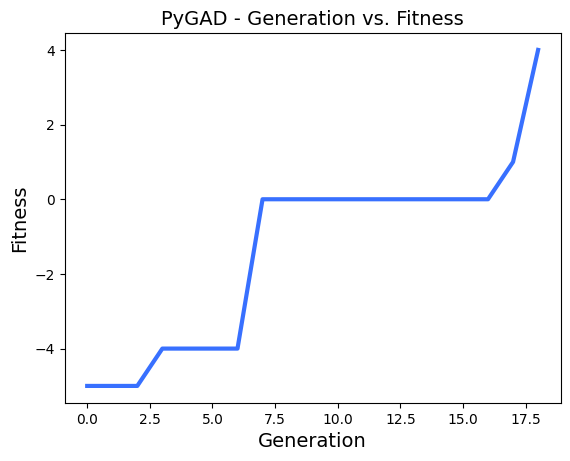

In [13]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [14]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5]
for i in range(5):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+5])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+10])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+15])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+20])
tablica4

[[0, 2, 5, 1, 0],
 [2, 3, 1, 0, 5],
 [4, 0, 3, 5, 2],
 [0, 5, 4, 0, 3],
 [5, 4, 0, 3, 1]]

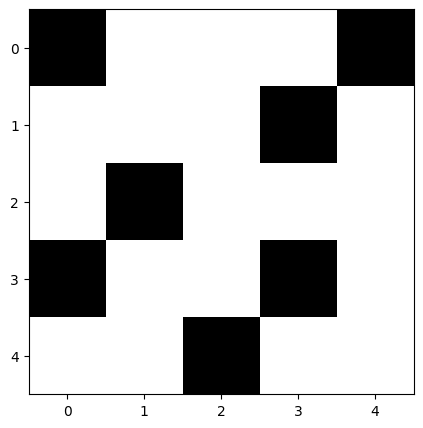

In [15]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

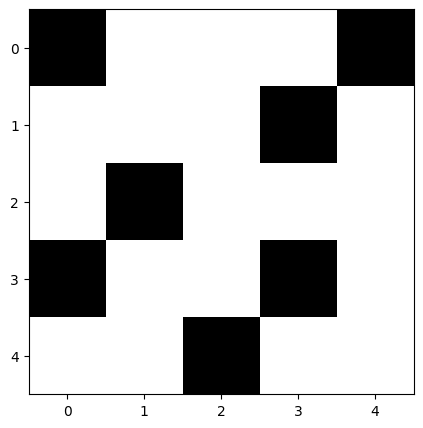

In [16]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [17]:
r1 = [3, 4, 2, 3, 4]
r2 = [2, 4, 1, 3, 5]
r3 = [5, 5, 4, 4, 1]
r4 = [4, 2, 5, 1, 5]
r5 = [5, 5, 2, 4, 2]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_4'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  4.417530298233032
Number of generations passed is : 36
Parameters of the best solution : [1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1.]
Fitness value of the best solution = 4


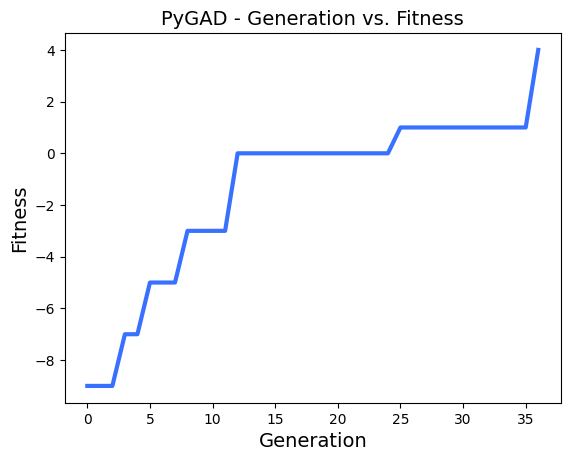

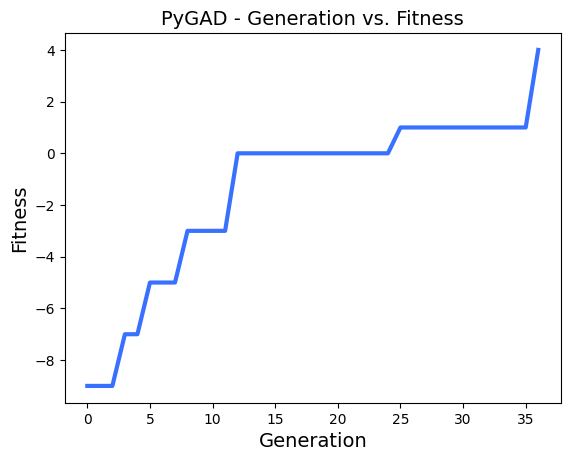

In [18]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [19]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5]
for i in range(5):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+5])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+10])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+15])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+20])
tablica4

[[3, 0, 2, 0, 4],
 [2, 4, 1, 3, 5],
 [5, 0, 4, 0, 1],
 [4, 2, 5, 1, 0],
 [0, 5, 0, 4, 2]]

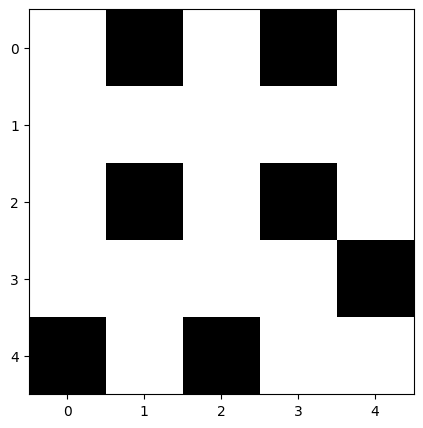

In [20]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

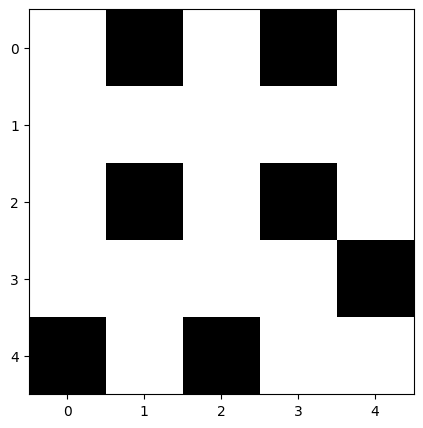

In [21]:
# wykres prawidłowego rozwiązania
rozwiazanie = [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(5):
    tablica3[0][i] = tablica3[0][i]*solution[i]
    tablica3[1][i] = tablica3[1][i]*solution[i+5]
    tablica3[2][i] = tablica3[2][i]*solution[i+10]
    tablica3[3][i] = tablica3[3][i]*solution[i+15]
    tablica3[4][i] = tablica3[4][i]*solution[i+20]

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [22]:
czasy1 = []
licznik1 = 0
for i in range(100):
    r1 = [2, 1, 1, 5, 5]
    r2 = [4, 2, 5, 1, 3]
    r3 = [2, 5, 3, 4, 3]
    r4 = [3, 1, 3, 5, 4]
    r5 = [1, 3, 4, 4, 1]
    t1 = [r1, r2, r3, r4, r5]

    r1 = [2, 2, 5, 1, 5]
    r2 = [2, 3, 1, 5, 5]
    r3 = [4, 4, 3, 5, 2]
    r4 = [4, 5, 4, 3, 3]
    r5 = [5, 4, 5, 3, 1]
    t2 = [r1, r2, r3, r4, r5]

    r1 = [3, 4, 2, 3, 4]
    r2 = [2, 4, 1, 3, 5]
    r3 = [5, 5, 4, 4, 1]
    r4 = [4, 2, 5, 1, 5]
    r5 = [5, 5, 2, 4, 2]
    t3 = [r1, r2, r3, r4, r5]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_4'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 4:
        czasy1.append(czas)
        licznik1 += 1

In [23]:
print('Efektywność: {}%'.format(licznik1))
print('Średni czas wykonania: {}'.format(np.mean(czasy1))) # dla prób z idealnym rozwiązaniem

Efektywność: 98%
Średni czas wykonania: 2.3263802893307743


## 6x6

In [24]:
# definiujemy parametry rozwiązania
# 1 - zostawiamy liczbę, 0 - kolorujemy na czarno
gene_space = [0, 1]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    # warunek, że czarne pola nie mogą stykać się bokami
    for m in [0, 6, 12, 18, 24, 30]:
        for n in range(5):
            if int(solution[m+n]) == 0:
                if int(solution[m+n+1]) == 0:
                    wynik -= 2
    for m in [0, 6, 12, 18, 24]:
        for n in range(6):
            if int(solution[m+n]) == 0:
                if int(solution[m+n+6]) == 0:
                    wynik -= 2
    
    tablica1 = [[0 for _ in range(6)] for _ in range(6)]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(6):
        tablica1[0][i] = int(tablica[0][i]*solution[i])
        tablica1[1][i] = int(tablica[1][i]*solution[i+6])
        tablica1[2][i] = int(tablica[2][i]*solution[i+12])
        tablica1[3][i] = int(tablica[3][i]*solution[i+18])
        tablica1[4][i] = int(tablica[4][i]*solution[i+24])
        tablica1[5][i] = int(tablica[5][i]*solution[i+30])
    
    # w kolumnie i wierszu liczby od 1 do 6 nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna liczba od 1 do 6, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        for j in kolumna:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
        for k in [count1, count2, count3, count4, count5, count6]:
            if k > 1:
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        # jeśli we wierszu występuje więcej niż jedna liczba od 1 do 6, to nakładamy karę
        for j in tablica1[i]:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
        for k in [count1, count2, count3, count4, count5, count6]:
            if k > 1:
                wynik -= 2*k
    
    # warunek, że nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(6)] for _ in range(6)]
    for i in range(6):
        tablica2[0][i] = int(tablica2[0][i]*solution[i])
        tablica2[1][i] = int(tablica2[1][i]*solution[i+6])
        tablica2[2][i] = int(tablica2[2][i]*solution[i+12])
        tablica2[3][i] = int(tablica2[3][i]*solution[i+18])
        tablica2[4][i] = int(tablica2[4][i]*solution[i+24])
        tablica2[5][i] = int(tablica2[5][i]*solution[i+30])
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej 1
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    # przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    komorka = [[i, j]]
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])
    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 8
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 8
    # wiemy, że rozwiązanie ma 10 zamalowanych komórek, więc nagradzamy za to
    if np.count_nonzero(solution == 0) == 10:
        wynik += 10
    return wynik

fitness_function = fitness_func

In [25]:
num_genes = 36 # tyle mamy pól, solution ma 64 geny
mutation_percent_genes = 3 # 36*0.03 czyli 1 gen sie zmieni

### 1)

In [26]:
r1 = [6, 3, 4, 3, 4, 5]
r2 = [4, 1, 5, 2, 6, 3]
r3 = [5, 5, 2, 3, 3, 2]
r4 = [5, 5, 6, 4, 2, 6]
r5 = [2, 3, 6, 5, 4, 6]
r6 = [1, 1, 3, 2, 5, 2]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  6.682388544082642
Number of generations passed is : 60
Parameters of the best solution : [1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
Fitness value of the best solution = 10


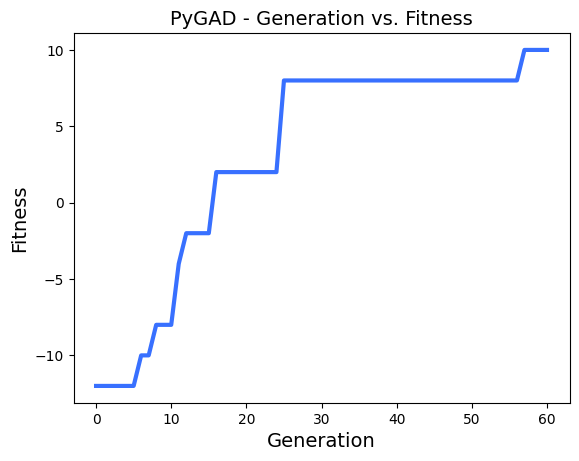

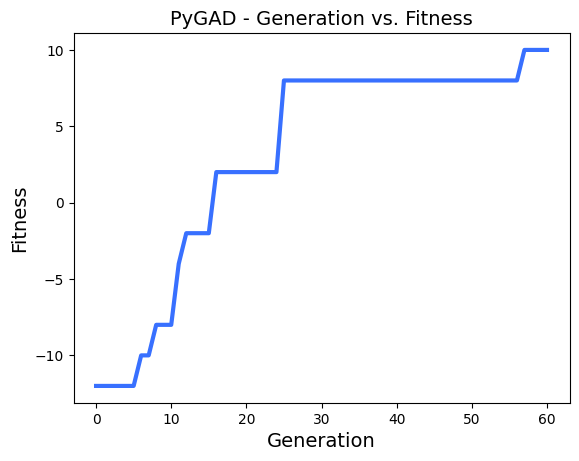

In [27]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [28]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6]
for i in range(6):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+6])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+12])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+18])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+24])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+30])
tablica4

[[6, 0, 4, 3, 0, 5],
 [4, 1, 5, 2, 6, 3],
 [5, 0, 0, 0, 3, 2],
 [0, 5, 6, 4, 2, 0],
 [2, 3, 0, 5, 4, 6],
 [1, 0, 3, 2, 5, 0]]

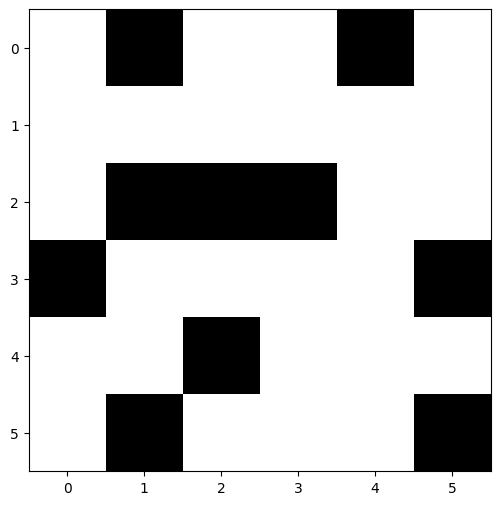

In [29]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

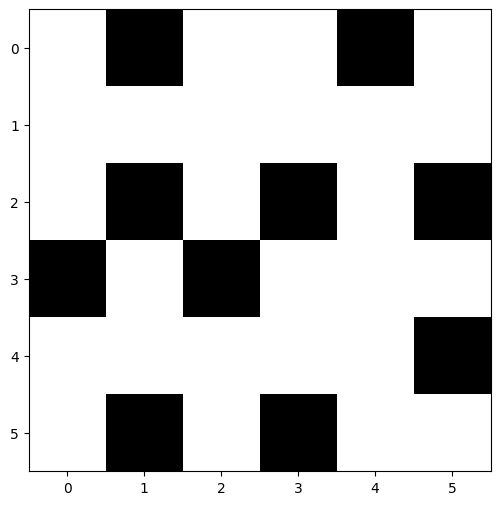

In [30]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    1, 0, 1, 1, 0, 1,
    1, 1, 1, 1, 1, 1,
    1, 0, 1, 0, 1, 0,
    0, 1, 0, 1, 1, 1,
    1, 1, 1, 1, 1, 0,
    1, 0, 1, 0, 1, 1
]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [31]:
r1 = [6, 5, 6, 3, 5, 2]
r2 = [1, 4, 4, 5, 3, 6]
r3 = [2, 3, 5, 1, 1, 1]
r4 = [6, 1, 3, 4, 6, 5]
r5 = [5, 4, 6, 4, 2, 3]
r6 = [4, 5, 3, 2, 5, 3]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  6.565289258956909
Number of generations passed is : 60
Parameters of the best solution : [1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
Fitness value of the best solution = 10


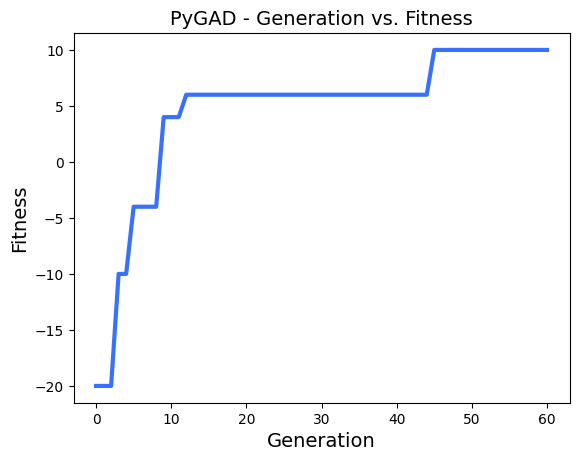

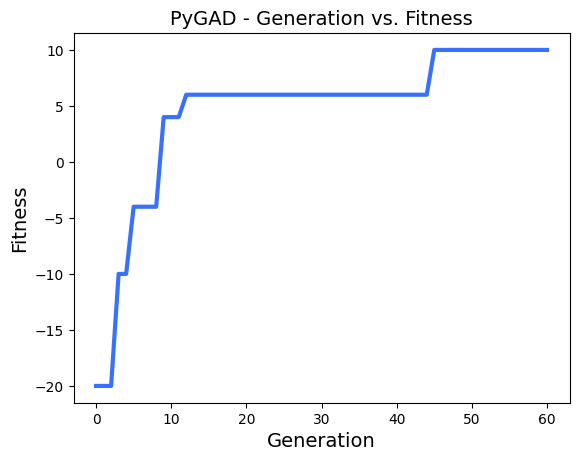

In [32]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [33]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6]
for i in range(6):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+6])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+12])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+18])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+24])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+30])
tablica4

[[6, 0, 0, 3, 5, 2],
 [1, 0, 4, 5, 3, 6],
 [2, 3, 5, 1, 0, 0],
 [0, 1, 0, 4, 6, 5],
 [5, 4, 6, 0, 2, 3],
 [4, 5, 3, 2, 0, 0]]

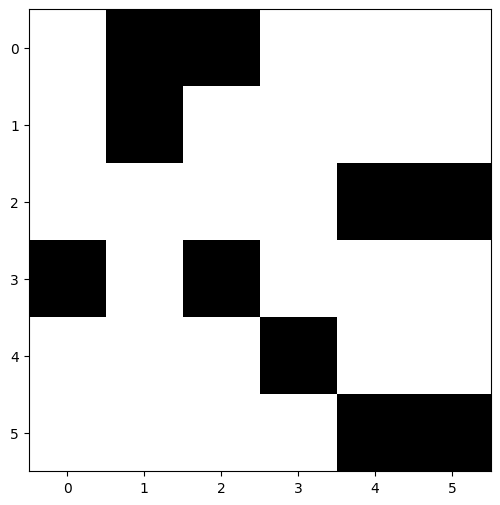

In [34]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

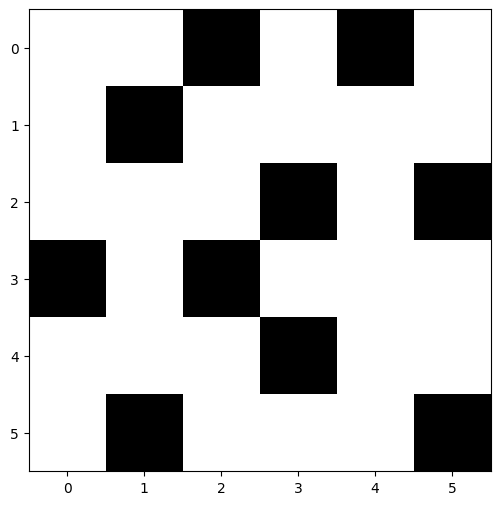

In [35]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    1, 1, 0, 1, 0, 1,
    1, 0, 1, 1, 1, 1,
    1, 1, 1, 0, 1, 0,
    0, 1, 0, 1, 1, 1,
    1, 1, 1, 0, 1, 1,
    1, 0, 1, 1, 1, 0
]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [36]:
r1 = [2, 3, 5, 5, 2, 3]
r2 = [5, 1, 5, 2, 6, 3]
r3 = [1, 2, 2, 6, 3, 1]
r4 = [2, 6, 1, 5, 4, 1]
r5 = [6, 2, 1, 2, 5, 3]
r6 = [1, 5, 6, 4, 1, 2]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  3.4153783321380615
Number of generations passed is : 31
Parameters of the best solution : [0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
Fitness value of the best solution = 18


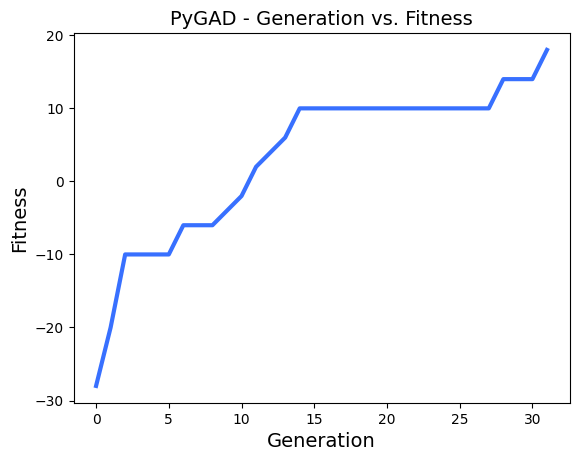

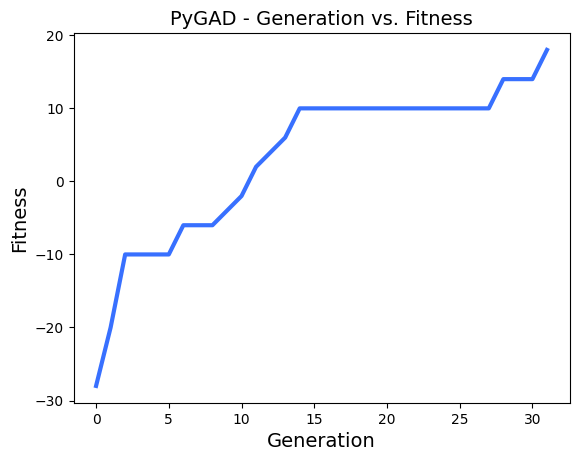

In [37]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [38]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6]
for i in range(6):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+6])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+12])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+18])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+24])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+30])
tablica4

[[0, 3, 5, 0, 2, 0],
 [5, 1, 0, 2, 6, 3],
 [1, 0, 2, 6, 3, 0],
 [2, 6, 0, 5, 4, 1],
 [6, 2, 1, 0, 5, 0],
 [0, 5, 6, 4, 1, 2]]

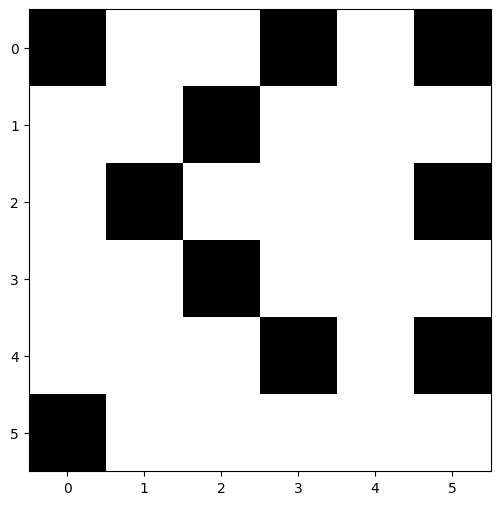

In [39]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

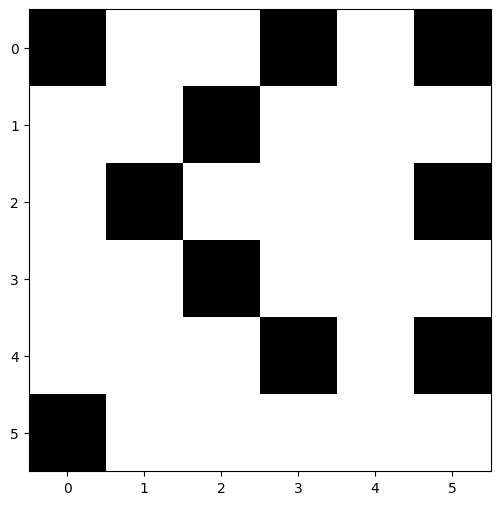

In [40]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    0, 1, 1, 0, 1, 0,
    1, 1, 0, 1, 1, 1,
    1, 0, 1, 1, 1, 0,
    1, 1, 0, 1, 1, 1,
    1, 1, 1, 0, 1, 0,
    0, 1, 1, 1, 1, 1
]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(6):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+6])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+12])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+18])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+24])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+30])

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [41]:
czasy2 = []
licznik2 = 0
for i in range(100):
    r1 = [6, 3, 4, 3, 4, 5]
    r2 = [4, 1, 5, 2, 6, 3]
    r3 = [5, 5, 2, 3, 3, 2]
    r4 = [5, 5, 6, 4, 2, 6]
    r5 = [2, 3, 6, 5, 4, 6]
    r6 = [1, 1, 3, 2, 5, 2]
    t1 = [r1, r2, r3, r4, r5, r6]

    r1 = [6, 5, 6, 3, 5, 2]
    r2 = [1, 4, 4, 5, 3, 6]
    r3 = [2, 3, 5, 1, 1, 1]
    r4 = [6, 1, 3, 4, 6, 5]
    r5 = [5, 4, 6, 4, 2, 3]
    r6 = [4, 5, 3, 2, 5, 3]
    t2 = [r1, r2, r3, r4, r5, r6]

    r1 = [2, 3, 5, 5, 2, 3]
    r2 = [5, 1, 5, 2, 6, 3]
    r3 = [1, 2, 2, 6, 3, 1]
    r4 = [2, 6, 1, 5, 4, 1]
    r5 = [6, 2, 1, 2, 5, 3]
    r6 = [1, 5, 6, 4, 1, 2]
    t3 = [r1, r2, r3, r4, r5, r6]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_18'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 18:
        czasy2.append(czas)
        licznik2 += 1

In [42]:
print('Efektywność: {}%'.format(licznik2))
print('Średni czas wykonania: {}'.format(np.mean(czasy2))) # dla prób z idealnym rozwiązaniem

Efektywność: 37%
Średni czas wykonania: 5.217688470273404


## 7x7

In [43]:
# definiujemy parametry rozwiązania
# 1 - zostawiamy liczbę, 0 - kolorujemy na czarno
gene_space = [0, 1]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    # warunek, że czarne pola nie mogą stykac się bokami
    for m in [0, 7, 14, 21, 28, 35, 42]:
        for n in range(6):
            if int(solution[m+n]) == 0:
                if int(solution[m+n+1]) == 0:
                    wynik -= 2
    for m in [0, 7, 14, 21, 28, 35]:
        for n in range(7):
            if int(solution[m+n]) == 0:
                if int(solution[m+n+7]) == 0:
                    wynik -= 2
    
    tablica1 = [[0 for _ in range(7)] for _ in range(7)]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(7):
        tablica1[0][i] = int(tablica[0][i]*solution[i])
        tablica1[1][i] = int(tablica[1][i]*solution[i+7])
        tablica1[2][i] = int(tablica[2][i]*solution[i+14])
        tablica1[3][i] = int(tablica[3][i]*solution[i+21])
        tablica1[4][i] = int(tablica[4][i]*solution[i+28])
        tablica1[5][i] = int(tablica[5][i]*solution[i+35])
        tablica1[6][i] = int(tablica[6][i]*solution[i+42])
    
    # w kolumnie i wierszu liczby od 1 do 7 nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna liczba od 1 do 7, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        count7 = 0
        for j in kolumna:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
            elif j == 7:
                count7 += 1
        for k in [count1, count2, count3, count4, count5, count6, count7]:
            if k > 1:
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        count7 = 0
        # jeśli we wierszu występuje więcej niż jedna liczba od 1 do 7, to nakładamy karę
        for j in tablica1[i]:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
            elif j == 7:
                count7 += 1
        for k in [count1, count2, count3, count4, count5, count6, count7]:
            if k > 1:
                wynik -= 2*k
    
    # warunek, że nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(7)] for _ in range(7)]
    for i in range(7):
        tablica2[0][i] = int(tablica2[0][i]*solution[i])
        tablica2[1][i] = int(tablica2[1][i]*solution[i+7])
        tablica2[2][i] = int(tablica2[2][i]*solution[i+14])
        tablica2[3][i] = int(tablica2[3][i]*solution[i+21])
        tablica2[4][i] = int(tablica2[4][i]*solution[i+28])
        tablica2[5][i] = int(tablica2[5][i]*solution[i+35])
        tablica2[6][i] = int(tablica2[6][i]*solution[i+42])
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej 1
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    # przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    komorka = [[i, j]]
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])
    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 8
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 8
    # wiemy, że rowiązanie ma 14 zamalowanych komórek, więc nagradzamy za to
    if np.count_nonzero(solution == 0) == 14:
        wynik += 10
    return wynik

fitness_function = fitness_func

In [44]:
num_genes = 49 # tyle mamy pól, solution ma 64 geny
mutation_percent_genes = 3 # 49*0.03 czyli 1 gen sie zmieni

### 1)

In [45]:
r1 = [6, 2, 4, 2, 3, 4, 6]
r2 = [6, 5, 6, 1, 7, 4, 3]
r3 = [7, 3, 5, 2, 5, 6, 7]
r4 = [7, 7, 6, 6, 2, 5, 5]
r5 = [2, 6, 3, 5, 2, 7, 4]
r6 = [3, 7, 7, 6, 5, 3, 6]
r7 = [3, 1, 7, 4, 7, 2, 5]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  7.945674419403076
Number of generations passed is : 60
Parameters of the best solution : [0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1.]
Fitness value of the best solution = 6


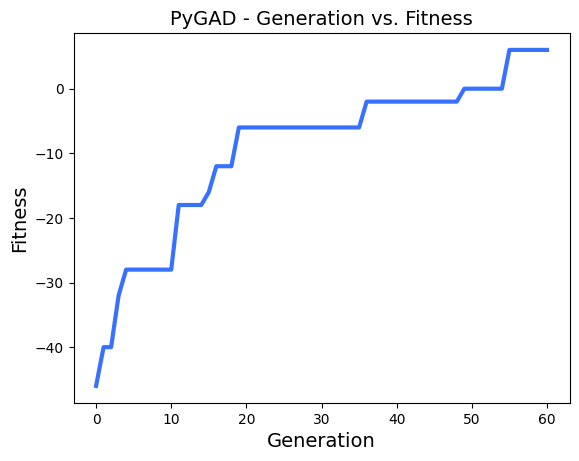

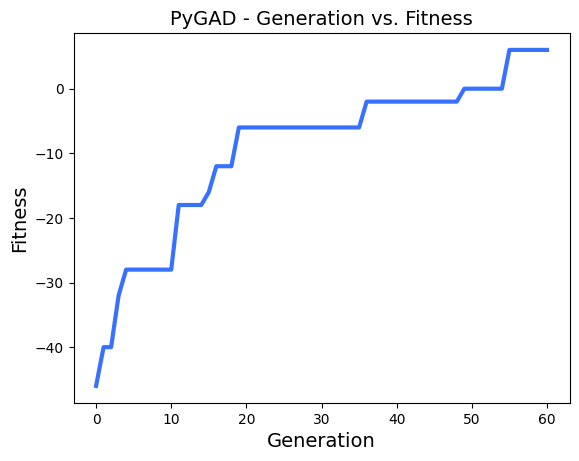

In [46]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [47]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(7):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+7])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+14])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+21])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+28])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+35])
    tablica4[6][i] = int(tablica4[6][i]*solution[i+42])
tablica4

[[0, 2, 4, 0, 3, 0, 6],
 [6, 5, 0, 1, 7, 4, 3],
 [0, 3, 5, 2, 0, 6, 0],
 [7, 0, 6, 0, 2, 5, 5],
 [2, 6, 3, 5, 0, 7, 4],
 [3, 7, 0, 6, 5, 3, 0],
 [0, 1, 7, 4, 0, 2, 5]]

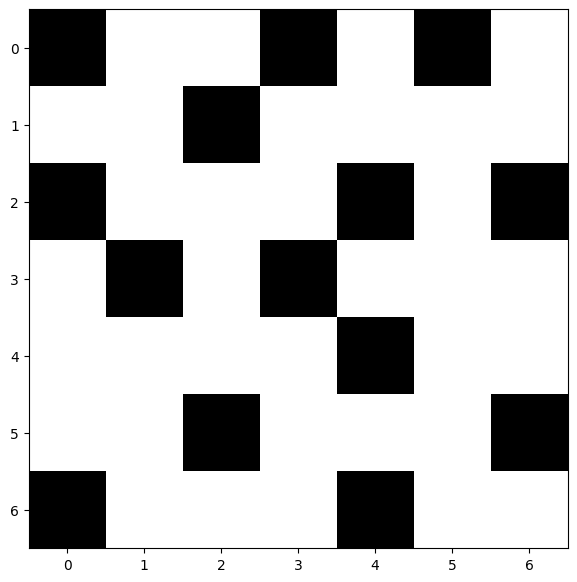

In [48]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

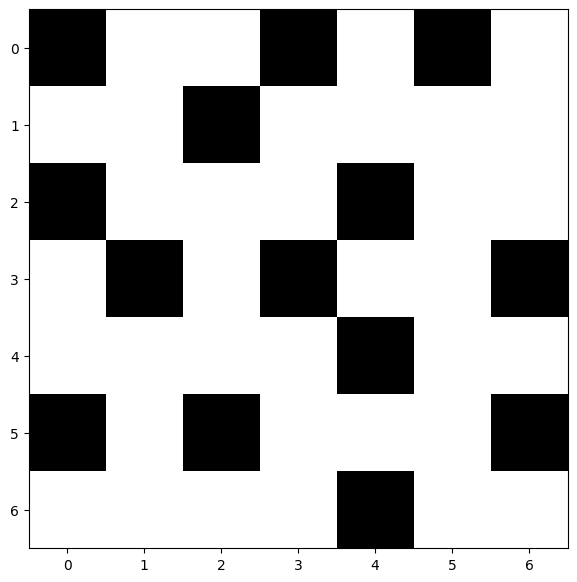

In [49]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    0, 1, 1, 0, 1, 0, 1,
    1, 1, 0, 1, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 1,
    1, 0, 1, 0, 1, 1, 0,
    1, 1, 1, 1, 0, 1, 1,
    0, 1, 0, 1, 1, 1, 0,
    1, 1, 1, 1, 0, 1, 1
]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [50]:
r1 = [1, 2, 4, 6, 6, 3, 5]
r2 = [3, 4, 4, 3, 2, 2, 1]
r3 = [2, 1, 5, 7, 5, 6, 3]
r4 = [5, 7, 7, 4, 1, 2, 4]
r5 = [5, 7, 3, 4, 5, 3, 4]
r6 = [3, 5, 3, 1, 6, 4, 7]
r7 = [4, 4, 1, 5, 1, 7, 5]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  7.295060396194458
Number of generations passed is : 60
Parameters of the best solution : [1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0.]
Fitness value of the best solution = -4


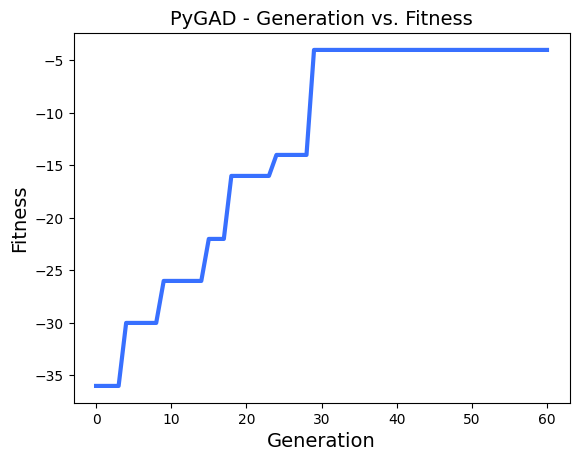

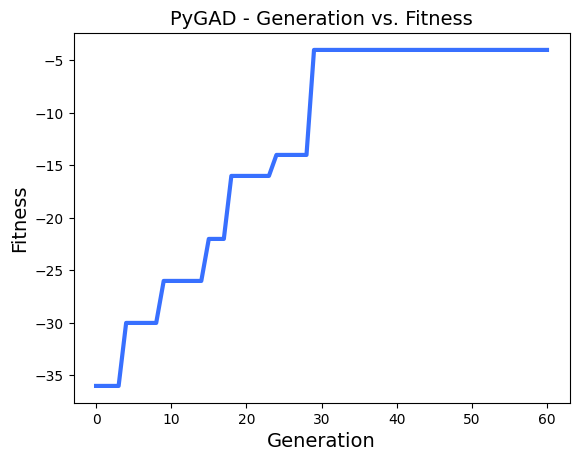

In [51]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [52]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(7):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+7])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+14])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+21])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+28])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+35])
    tablica4[6][i] = int(tablica4[6][i]*solution[i+42])
tablica4

[[1, 2, 4, 6, 0, 3, 5],
 [0, 4, 0, 3, 2, 0, 1],
 [0, 1, 5, 7, 0, 6, 3],
 [0, 7, 0, 4, 1, 2, 0],
 [5, 7, 3, 0, 5, 0, 4],
 [3, 5, 0, 1, 6, 4, 7],
 [4, 0, 1, 5, 0, 7, 0]]

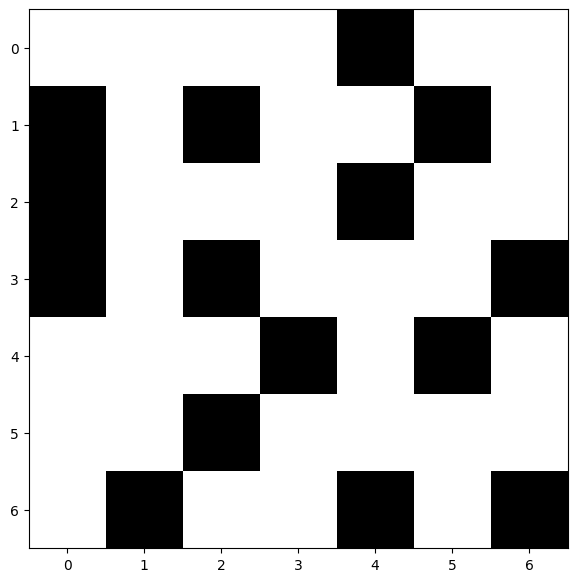

In [53]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

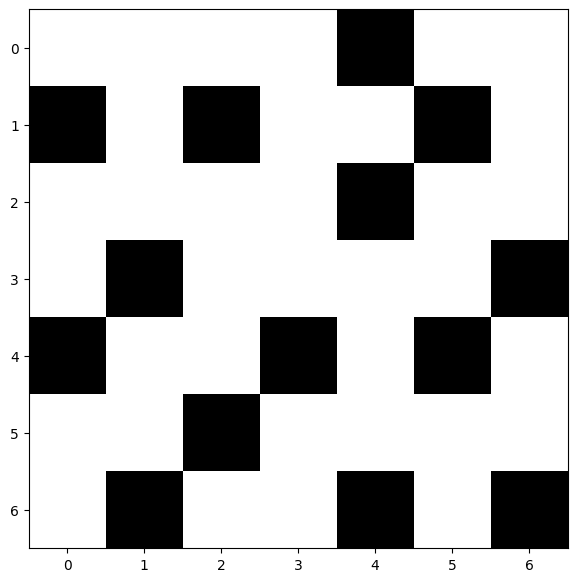

In [54]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    1, 1, 1, 1, 0, 1, 1,
    0, 1, 0, 1, 1, 0, 1,
    1, 1, 1, 1, 0, 1, 1,
    1, 0, 1, 1, 1, 1, 0,
    0, 1, 1, 0, 1, 0, 1,
    1, 1, 0, 1, 1, 1, 1,
    1, 0, 1, 1, 0, 1, 0
]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [55]:
r1 = [5, 6, 1, 2, 5, 7, 7]
r2 = [2, 2, 5, 6, 1, 6, 3]
r3 = [7, 5, 3, 7, 4, 3, 1]
r4 = [4, 3, 7, 7, 2, 5, 3]
r5 = [7, 3, 4, 5, 2, 3, 2]
r6 = [1, 2, 2, 3, 5, 4, 7]
r7 = [4, 4, 2, 6, 1, 1, 2]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_18'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  9.043043851852417
Number of generations passed is : 60
Parameters of the best solution : [1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0.]
Fitness value of the best solution = 6


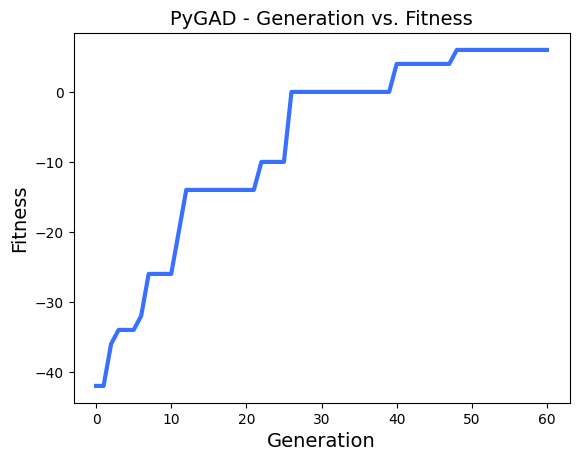

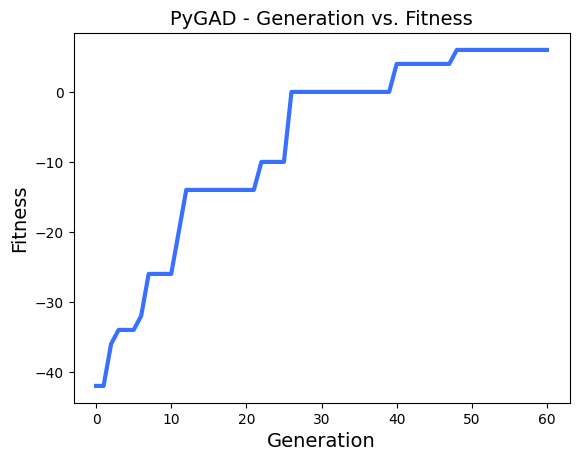

In [56]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [57]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(7):
    tablica4[0][i] = int(tablica4[0][i]*solution[i])
    tablica4[1][i] = int(tablica4[1][i]*solution[i+7])
    tablica4[2][i] = int(tablica4[2][i]*solution[i+14])
    tablica4[3][i] = int(tablica4[3][i]*solution[i+21])
    tablica4[4][i] = int(tablica4[4][i]*solution[i+28])
    tablica4[5][i] = int(tablica4[5][i]*solution[i+35])
    tablica4[6][i] = int(tablica4[6][i]*solution[i+42])
tablica4

[[5, 6, 1, 2, 0, 7, 0],
 [2, 0, 5, 0, 1, 6, 3],
 [0, 5, 3, 7, 0, 3, 1],
 [4, 3, 0, 7, 2, 5, 0],
 [7, 0, 4, 5, 0, 3, 2],
 [1, 2, 0, 3, 5, 4, 7],
 [0, 4, 2, 6, 0, 1, 0]]

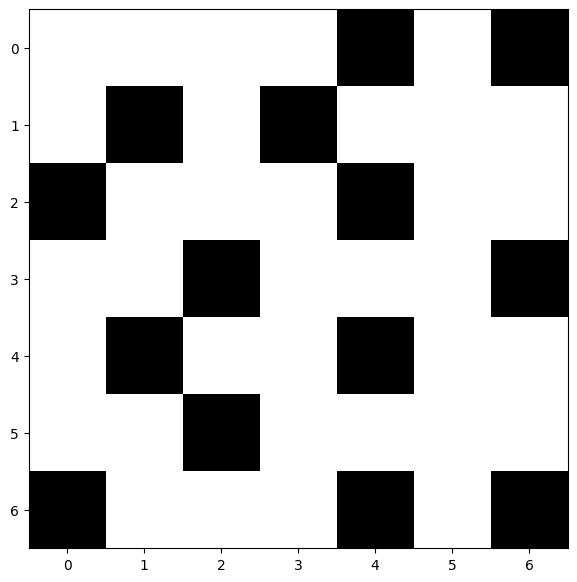

In [58]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

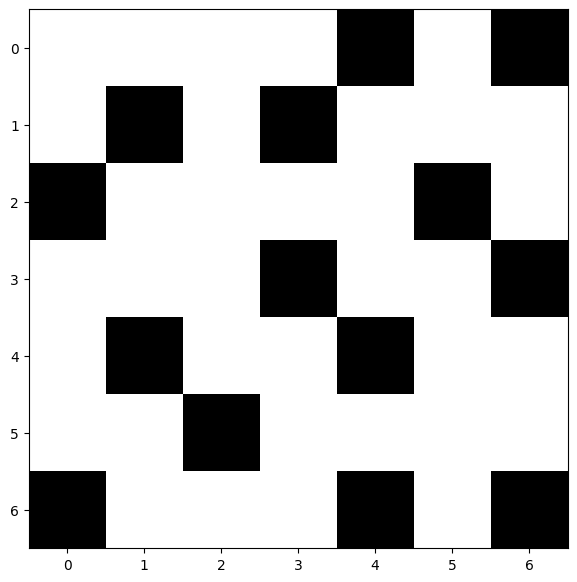

In [59]:
# wykres prawidłowego rozwiązania
rozwiazanie = [
    1, 1, 1, 1, 0, 1, 0,
    1, 0, 1, 0, 1, 1, 1,
    0, 1, 1, 1, 1, 0, 1,
    1, 1, 1, 0, 1, 1, 0,
    1, 0, 1, 1, 0, 1, 1,
    1, 1, 0, 1, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 0
]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(7):
    tablica3[0][i] = int(tablica3[0][i]*solution[i])
    tablica3[1][i] = int(tablica3[1][i]*solution[i+7])
    tablica3[2][i] = int(tablica3[2][i]*solution[i+14])
    tablica3[3][i] = int(tablica3[3][i]*solution[i+21])
    tablica3[4][i] = int(tablica3[4][i]*solution[i+28])
    tablica3[5][i] = int(tablica3[5][i]*solution[i+35])
    tablica3[6][i] = int(tablica3[6][i]*solution[i+42])

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [60]:
czasy3 = []
licznik3 = 0
for i in range(100):
    r1 = [6, 2, 4, 2, 3, 4, 6]
    r2 = [6, 5, 6, 1, 7, 4, 3]
    r3 = [7, 3, 5, 2, 5, 6, 7]
    r4 = [7, 7, 6, 6, 2, 5, 5]
    r5 = [2, 6, 3, 5, 2, 7, 4]
    r6 = [3, 7, 7, 6, 5, 3, 6]
    r7 = [3, 1, 7, 4, 7, 2, 5]
    t1 = [r1, r2, r3, r4, r5, r6, r7]

    r1 = [1, 2, 4, 6, 6, 3, 5]
    r2 = [3, 4, 4, 3, 2, 2, 1]
    r3 = [2, 1, 5, 7, 5, 6, 3]
    r4 = [5, 7, 7, 4, 1, 2, 4]
    r5 = [5, 7, 3, 4, 5, 3, 4]
    r6 = [3, 5, 3, 1, 6, 4, 7]
    r7 = [4, 4, 1, 5, 1, 7, 5]
    t2 = [r1, r2, r3, r4, r5, r6, r7]

    r1 = [5, 6, 1, 2, 5, 7, 7]
    r2 = [2, 2, 5, 6, 1, 6, 3]
    r3 = [7, 5, 3, 7, 4, 3, 1]
    r4 = [4, 3, 7, 7, 2, 5, 3]
    r5 = [7, 3, 4, 5, 2, 3, 2]
    r6 = [1, 2, 2, 3, 5, 4, 7]
    r7 = [4, 4, 2, 6, 1, 1, 2]
    t3 = [r1, r2, r3, r4, r5, r6, r7]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_18'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 18:
        czasy3.append(czas)
        licznik3 += 1

In [61]:
print('Efektywność: {}%'.format(licznik3))
print('Średni czas wykonania: {}'.format(np.mean(czasy3))) # dla prób z idealnym rozwiązaniem

Efektywność: 11%
Średni czas wykonania: 7.181068940596147


In [62]:
df = pd.DataFrame(data=
                  {'Efektywność [%]': [licznik1, licznik2, licznik3],
                   'Średni czas': [np.mean(czasy1), np.mean(czasy2), np.mean(czasy3)]},
                  index=['5x5', '6x6', '7x7'])
df

,Efektywność [%],Średni czas
5x5,98,2.326380
6x6,37,5.217688
7x7,11,7.181069


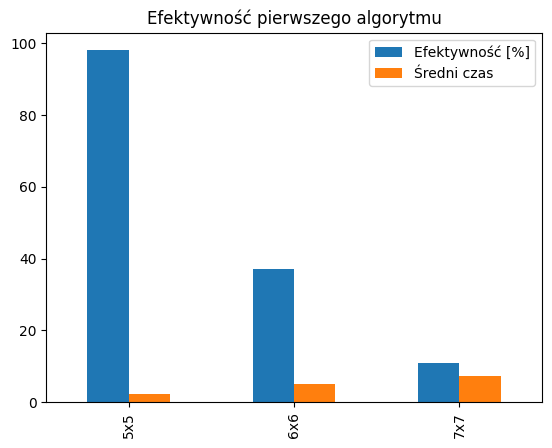

In [63]:
# wykres tabelki
df.plot.bar()
plt.title('Efektywność pierwszego algorytmu')
plt.show()

In [64]:
# Algorytm działa, rozwiązuje łamigłówki, ale jego efektywność drastycznie spada wraz ze zwiększaniem się tablicy.
# Efektywność średnich i dużych inputów nie przekracza 50%.

## Drugi sposób rozwiązania zadania

In [65]:
# Co jeśli zakodujemy rozwiązanie jako współrzędne zer?
# Chromosom (solution) będzie długości 2*liczba zer (najpierw pierwsza współrzędna, potem druga),
# gene_space to liczby całkowite od 0 do len(tablica)-1.

## 5x5

In [66]:
# definiujemy parametry rozwiązania
# dwie kolejne liczby to współrzędne komórki, którą należy zamalować na czarno
gene_space = [0, 1, 2, 3, 4]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    # zmieniliśmy sposób kodowania rowiązania, ogólny zarys funkcji jest taki sam
    # sprawdzamy, czy zasady łamigłówki są spełnione
    
    # chcemy mieć liczbę zer równą solution/2, więc pary współrzędnych nie mogą się powtarzać
    for i in range(int(len(solution)/2)):
        for j in range(int(len(solution)/2)):
            if i!=j:
                if solution[i*2] == solution[j*2] and solution[i*2+1] == solution[j*2+1]:
                    # jeśli się powtarzają to nakładamy karę
                    wynik -= 1
    
    # warunek, że nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(len(tablica))] for _ in range(len(tablica))]
    for i in range(int(len(solution)/2)):
        tablica2[int(solution[i*2])][int(solution[2*i+1])] = 0
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej 1
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    # przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    komorka = [[i, j]]
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])

    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 2
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 2
    
    # warunek, że czarne pola nie mogą stykać się bokami
    for m in range(len(tablica)):
        for n in range(len(tablica)-1):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m][n+1]) == 0:
                    wynik -= 1
    for m in range(len(tablica)-1):
        for n in range(len(tablica)):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m+1][n]) == 0:
                    wynik -= 1
    
    tablica1 = [[0 for _ in range(len(tablica))] for _ in range(len(tablica))]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(len(tablica)):
        for j in range(len(tablica)):
            tablica1[i][j] = int(tablica[i][j]*tablica2[i][j])

    # warunek, że w kolumnie i wierszu liczby nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna liczba taka sama liczba, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        for j in kolumna:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
        for k in [count1, count2, count3, count4, count5]:
            if k > 1:
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        # jeśli we wierszu występuje więcej niż jedna liczba od 1 do 5, to nakładamy karę
        for j in tablica1[i]:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
        for k in [count1, count2, count3, count4, count5]:
            if k > 1:
                wynik -= 2*k
    
    return wynik

fitness_function = fitness_func

In [67]:
# Ustawienia wielkości populacji i ilości pokoleń zostawimy takie jak przy pierwszym algorytmie,
# by na końcu można było porównać wyniki obu podejść.

In [68]:
# ile chromosomów w populacji
sol_per_pop = 1000 #600
# ile genów ma chromosom
num_genes = 14 # powinniśmy zamalować 7 kratek, solution ma 14 genów

# ile wylaniamy rodziców do "rozmanażania" (okolo 50% populacji)
num_parents_mating = 500 #300
# ile pokoleń
num_generations = 60 #50
# ilu rodziców zachować (kilka procent)
keep_parents = 2

# jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "rank"

# w ilu punktach robic krzyzowanie?
#single_point, two_points, uniform, scattered
crossover_type = "single_point"

# mutacja ma dzialac na ilu procent genów?
#random, swap - zamienia miejscami dwa geny, inversion - zmienia kolejność fragmentu chromosomu, scramble, adaptive
#displacament - przeniesienie części genów w inne miejsce
mutation_type = "random" # w tym podjeściu random przestawia komórki w inne miejsca, co może być dobrym rozwiązaniem
mutation_percent_genes = 8 # 14*0.08 czyli 1 gen sie zmieni

### 1)

In [69]:
r1 = [2, 1, 1, 5, 5]
r2 = [4, 2, 5, 1, 3]
r3 = [2, 5, 3, 4, 3]
r4 = [3, 1, 3, 5, 4]
r5 = [1, 3, 4, 4, 1]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  0.6945509910583496
Number of generations passed is : 8
Parameters of the best solution : [0. 1. 2. 4. 2. 0. 3. 2. 4. 3. 0. 3. 4. 0.]
Fitness value of the best solution = 2


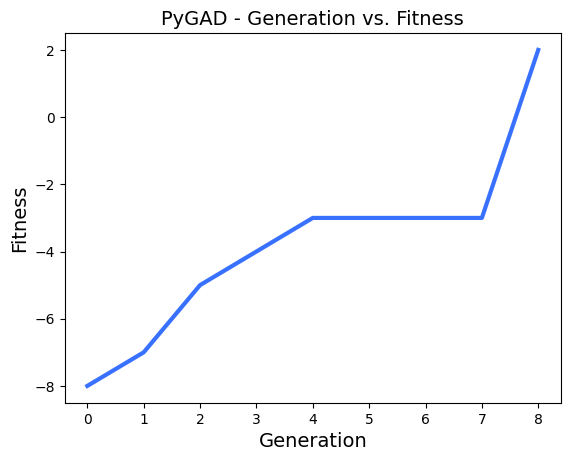

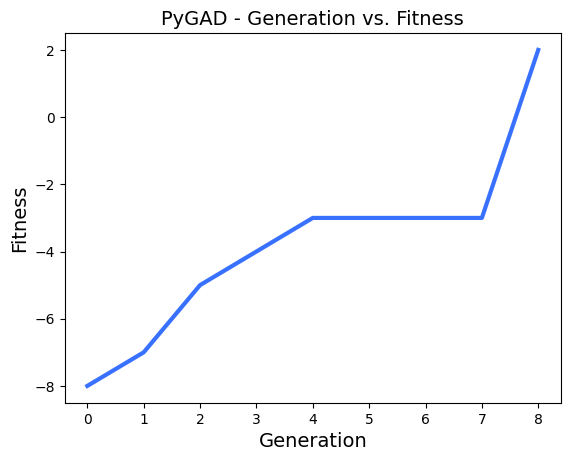

In [70]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [71]:
# najlepsze wyłonione rozwiązanie
r1 = [2, 1, 1, 5, 5]
r2 = [4, 2, 5, 1, 3]
r3 = [2, 5, 3, 4, 3]
r4 = [3, 1, 3, 5, 4]
r5 = [1, 3, 4, 4, 1]
tablica = [r1, r2, r3, r4, r5]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[2, 0, 1, 0, 5],
 [4, 2, 5, 1, 3],
 [0, 5, 3, 4, 0],
 [3, 1, 0, 5, 4],
 [0, 3, 4, 0, 1]]

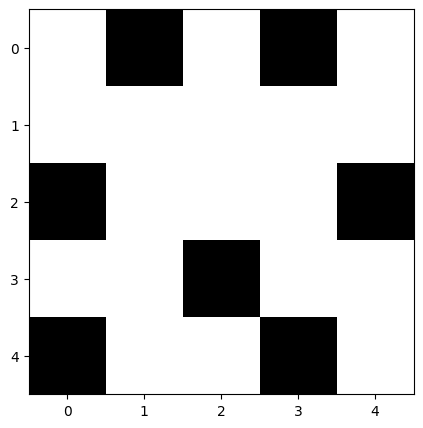

In [72]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

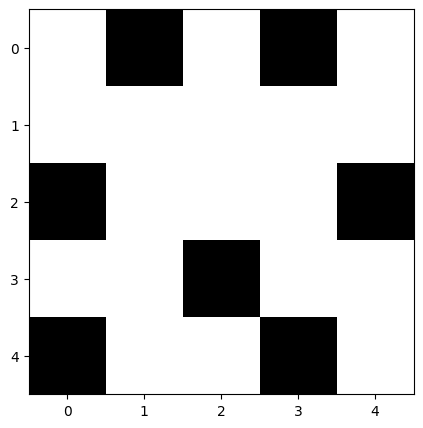

In [73]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 1, 0, 3, 2, 0, 2, 4, 3, 2, 4, 0, 4, 3]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [74]:
r1 = [2, 2, 5, 1, 5]
r2 = [2, 3, 1, 5, 5]
r3 = [4, 4, 3, 5, 2]
r4 = [4, 5, 4, 3, 3]
r5 = [5, 4, 5, 3, 1]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  1.0522041320800781
Number of generations passed is : 13
Parameters of the best solution : [1. 3. 0. 4. 0. 0. 2. 1. 3. 3. 4. 2. 3. 0.]
Fitness value of the best solution = 2


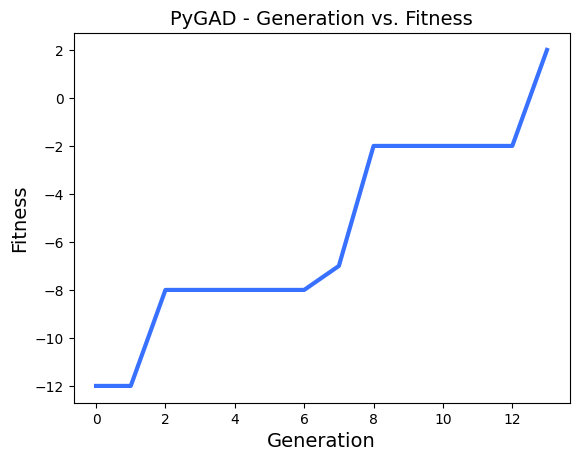

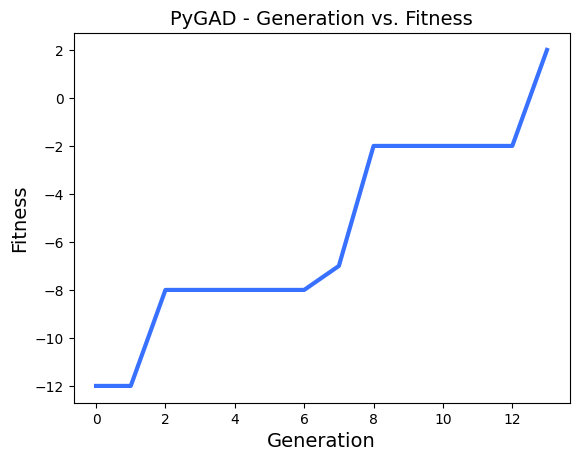

In [75]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [76]:
# najlepsze wyłonione rozwiązanie
r1 = [2, 2, 5, 1, 5]
r2 = [2, 3, 1, 5, 5]
r3 = [4, 4, 3, 5, 2]
r4 = [4, 5, 4, 3, 3]
r5 = [5, 4, 5, 3, 1]
tablica = [r1, r2, r3, r4, r5]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[0, 2, 5, 1, 0],
 [2, 3, 1, 0, 5],
 [4, 0, 3, 5, 2],
 [0, 5, 4, 0, 3],
 [5, 4, 0, 3, 1]]

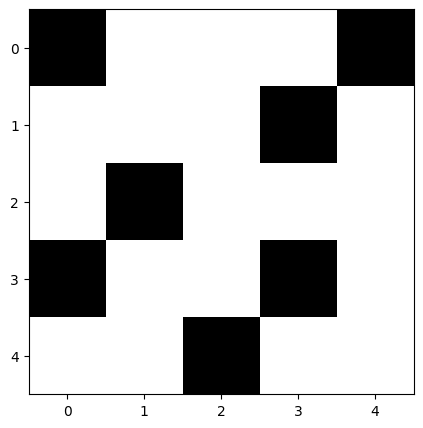

In [77]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

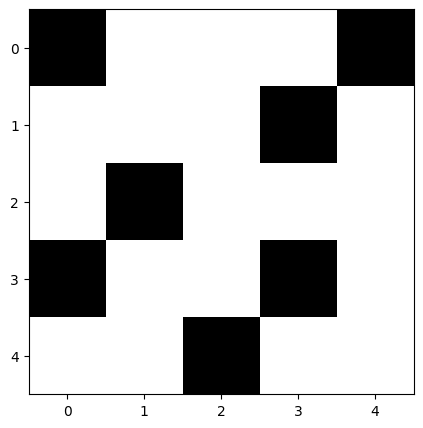

In [78]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 0, 0, 4, 1, 3, 2, 1, 3, 0, 3, 3, 4, 2]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [79]:
r1 = [3, 4, 2, 3, 4]
r2 = [2, 4, 1, 3, 5]
r3 = [5, 5, 4, 4, 1]
r4 = [4, 2, 5, 1, 5]
r5 = [5, 5, 2, 4, 2]
tablica = [r1, r2, r3, r4, r5]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  1.5435640811920166
Number of generations passed is : 19
Parameters of the best solution : [4. 0. 2. 1. 0. 1. 4. 2. 3. 4. 2. 3. 0. 3.]
Fitness value of the best solution = 2


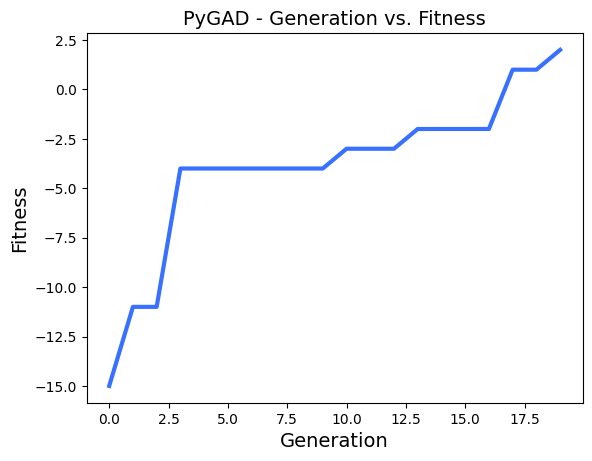

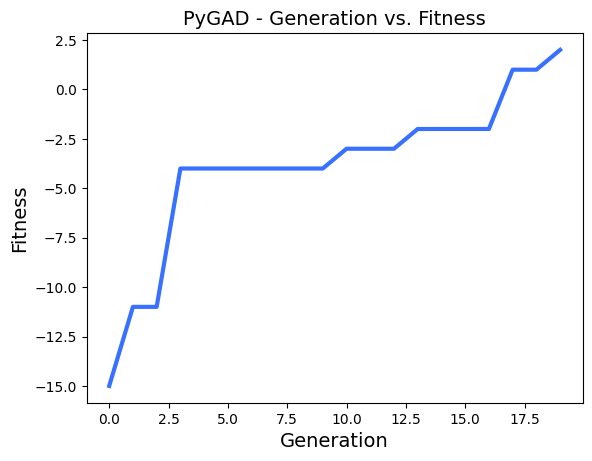

In [80]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [81]:
# najlepsze wyłonione rozwiązanie
r1 = [3, 4, 2, 3, 4]
r2 = [2, 4, 1, 3, 5]
r3 = [5, 5, 4, 4, 1]
r4 = [4, 2, 5, 1, 5]
r5 = [5, 5, 2, 4, 2]
tablica = [r1, r2, r3, r4, r5]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[3, 0, 2, 0, 4],
 [2, 4, 1, 3, 5],
 [5, 0, 4, 0, 1],
 [4, 2, 5, 1, 0],
 [0, 5, 0, 4, 2]]

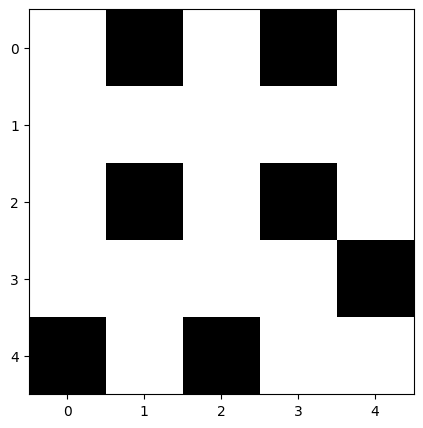

In [82]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

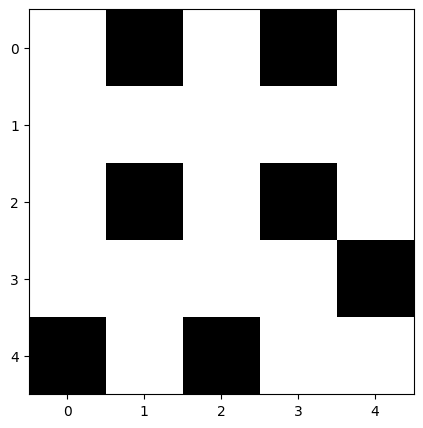

In [83]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 1, 0, 3, 2, 1, 2, 3, 3, 4, 4, 0, 4, 2]
solution = rozwiazanie
tablica3 = [[1 for i in range(5)] for i in range(5)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(5, 5))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [84]:
czasy11 = []
licznik11 = 0
for i in range(100):
    r1 = [2, 1, 1, 5, 5]
    r2 = [4, 2, 5, 1, 3]
    r3 = [2, 5, 3, 4, 3]
    r4 = [3, 1, 3, 5, 4]
    r5 = [1, 3, 4, 4, 1]
    t1 = [r1, r2, r3, r4, r5]

    r1 = [2, 2, 5, 1, 5]
    r2 = [2, 3, 1, 5, 5]
    r3 = [4, 4, 3, 5, 2]
    r4 = [4, 5, 4, 3, 3]
    r5 = [5, 4, 5, 3, 1]
    t2 = [r1, r2, r3, r4, r5]

    r1 = [3, 4, 2, 3, 4]
    r2 = [2, 4, 1, 3, 5]
    r3 = [5, 5, 4, 4, 1]
    r4 = [4, 2, 5, 1, 5]
    r5 = [5, 5, 2, 4, 2]
    t3 = [r1, r2, r3, r4, r5]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_2'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 2:
        czasy11.append(czas)
        licznik11 += 1

In [85]:
print('Efektywność: {}%'.format(licznik11))
print('Średni czas wykonania: {}'.format(np.mean(czasy11))) # dla prób z idealnym rozwiązaniem

Efektywność: 100%
Średni czas wykonania: 1.3413503003120422


## 6x6

In [86]:
# definiujemy parametry rozwiązania
# dwie kolejne liczby to współrzędne komórki, którą należy zamalować na czarno
gene_space = [0, 1, 2, 3, 4, 5]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    
    # chcemy mieć liczbę zer równą solution/2, więc pary współrzędnych nie mogą się powtarzać
    for i in range(int(len(solution)/2)):
        for j in range(int(len(solution)/2)):
            if i!=j:
                if solution[i*2] == solution[j*2] and solution[i*2+1] == solution[j*2+1]:
                    # jeśli się powtarzają to nakładamy karę
                    wynik -= 1
    
    # warunek, że nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(len(tablica))] for _ in range(len(tablica))]
    for i in range(int(len(solution)/2)):
        tablica2[int(solution[i*2])][int(solution[2*i+1])] = 0
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej 1
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    # przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    komorka = [[i, j]]
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])

    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 2
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 2
    
    # warunek, że czarne pola nie mogą stykac się bokami
    for m in range(len(tablica)):
        for n in range(len(tablica)-1):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m][n+1]) == 0:
                    wynik -= 1
    for m in range(len(tablica)-1):
        for n in range(len(tablica)):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m+1][n]) == 0:
                    wynik -= 1
    
    tablica1 = [[0 for _ in range(len(tablica))] for _ in range(len(tablica))]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(len(tablica)):
        for j in range(len(tablica)):
            tablica1[i][j] = int(tablica[i][j]*tablica2[i][j])

    # warunek, że w kolumnie i wierszu liczby nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna taka sama liczba, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        for j in kolumna:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
        for k in [count1, count2, count3, count4, count5, count6]:
            if k > 1:
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        # jeśli we wierszu występuje więcej niż jedna taka sama liczba, to nakładamy karę
        for j in tablica1[i]:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
        for k in [count1, count2, count3, count4, count5, count6]:
            if k > 1:
                wynik -= 2*k
    
    return wynik

fitness_function = fitness_func

In [87]:
num_genes = 20 # powinniśmy zamalować 10 kratek, solution ma 20 genów
mutation_percent_genes = 5 # 20*0.05 czyli 1 gen sie zmieni

### 1)

In [88]:
r1 = [6, 3, 4, 3, 4, 5]
r2 = [4, 1, 5, 2, 6, 3]
r3 = [5, 5, 2, 3, 3, 2]
r4 = [5, 5, 6, 4, 2, 6]
r5 = [2, 3, 6, 5, 4, 6]
r6 = [1, 1, 3, 2, 5, 2]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  5.804481029510498
Number of generations passed is : 49
Parameters of the best solution : [5. 3. 4. 5. 0. 1. 2. 3. 0. 4. 2. 1. 2. 5. 3. 0. 3. 2. 5. 1.]
Fitness value of the best solution = 2


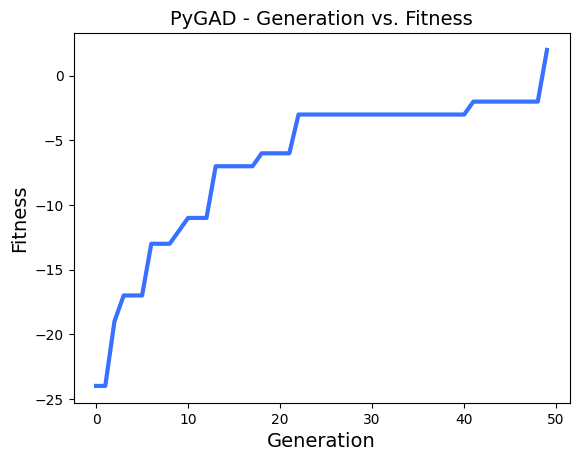

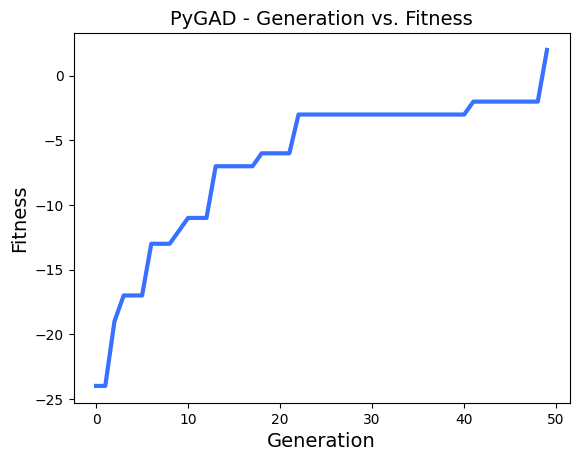

In [89]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [90]:
# najlepsze wyłonione rozwiązanie
r1 = [6, 3, 4, 3, 4, 5]
r2 = [4, 1, 5, 2, 6, 3]
r3 = [5, 5, 2, 3, 3, 2]
r4 = [5, 5, 6, 4, 2, 6]
r5 = [2, 3, 6, 5, 4, 6]
r6 = [1, 1, 3, 2, 5, 2]
tablica = [r1, r2, r3, r4, r5, r6]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[6, 0, 4, 3, 0, 5],
 [4, 1, 5, 2, 6, 3],
 [5, 0, 2, 0, 3, 0],
 [0, 5, 0, 4, 2, 6],
 [2, 3, 6, 5, 4, 0],
 [1, 0, 3, 0, 5, 2]]

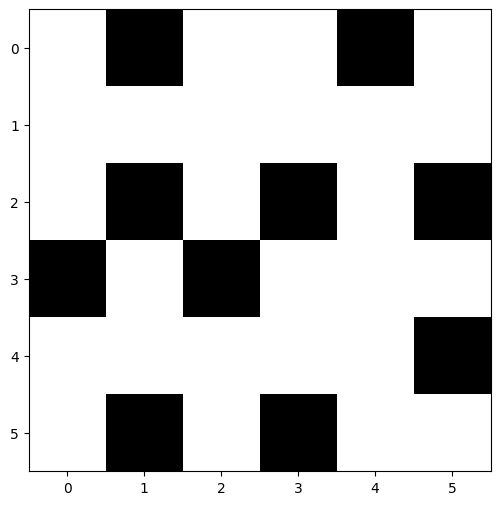

In [91]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

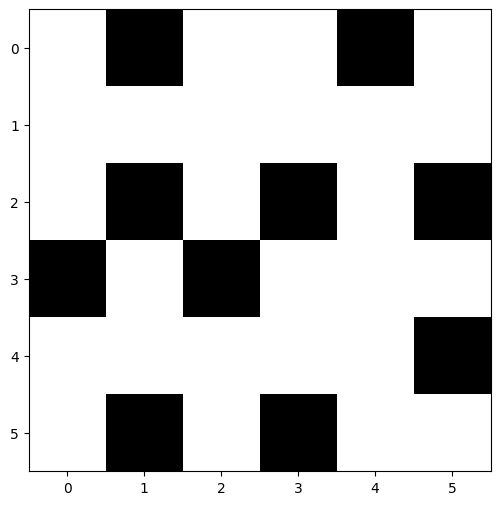

In [92]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 1, 0, 4, 2, 1, 2, 3, 2, 5, 3, 0, 3, 2, 4, 5, 5, 1, 5, 3]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [93]:
r1 = [6, 5, 6, 3, 5, 2]
r2 = [1, 4, 4, 5, 3, 6]
r3 = [2, 3, 5, 1, 1, 1]
r4 = [6, 1, 3, 4, 6, 5]
r5 = [5, 4, 6, 4, 2, 3]
r6 = [4, 5, 3, 2, 5, 3]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  3.8756165504455566
Number of generations passed is : 36
Parameters of the best solution : [4. 3. 1. 1. 0. 4. 3. 2. 2. 5. 3. 0. 5. 1. 0. 2. 2. 3. 5. 5.]
Fitness value of the best solution = 2


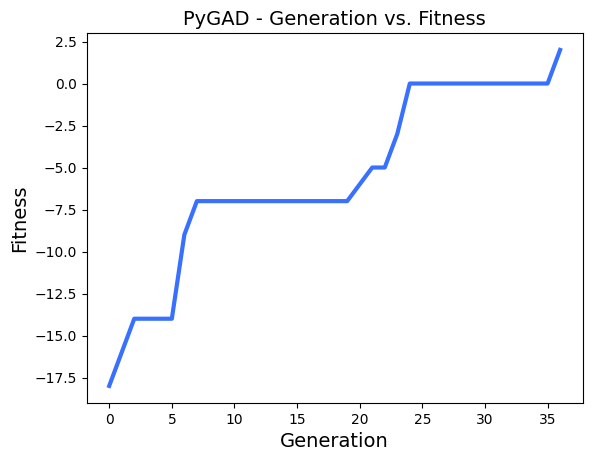

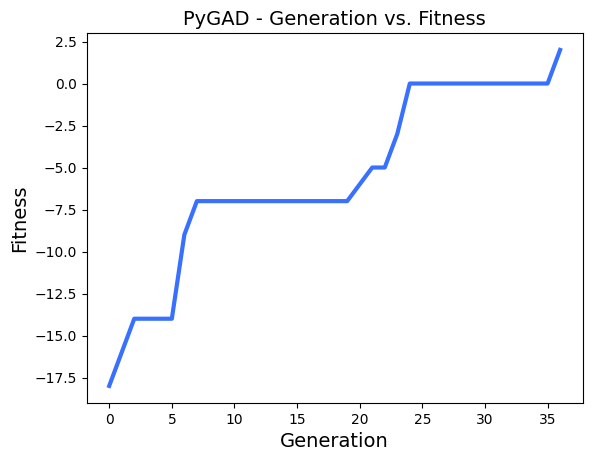

In [94]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [95]:
# najlepsze wyłonione rozwiązanie
r1 = [6, 5, 6, 3, 5, 2]
r2 = [1, 4, 4, 5, 3, 6]
r3 = [2, 3, 5, 1, 1, 1]
r4 = [6, 1, 3, 4, 6, 5]
r5 = [5, 4, 6, 4, 2, 3]
r6 = [4, 5, 3, 2, 5, 3]
tablica = [r1, r2, r3, r4, r5, r6]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[6, 5, 0, 3, 0, 2],
 [1, 0, 4, 5, 3, 6],
 [2, 3, 5, 0, 1, 0],
 [0, 1, 0, 4, 6, 5],
 [5, 4, 6, 0, 2, 3],
 [4, 0, 3, 2, 5, 0]]

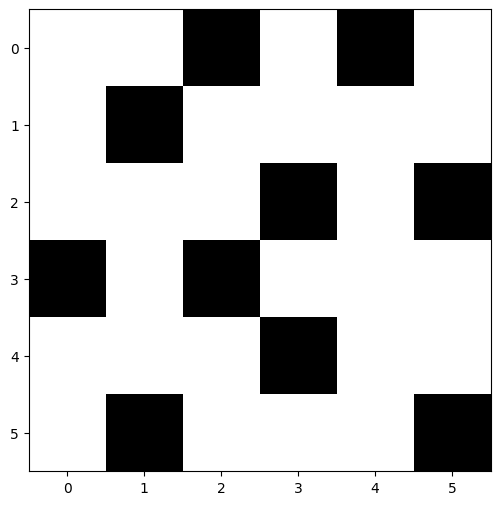

In [96]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

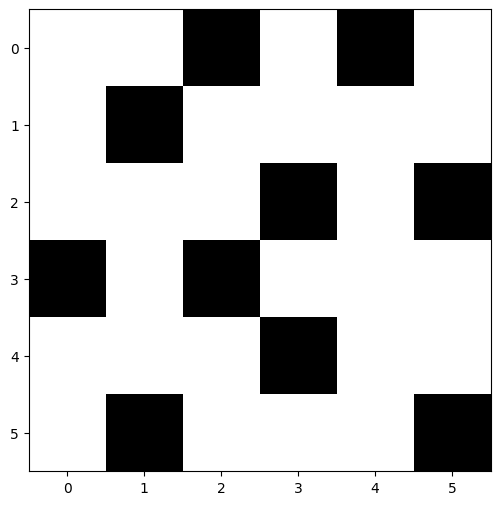

In [97]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 2, 0, 4, 1, 1, 2, 3, 2, 5, 3, 0, 3, 2, 4, 3, 5, 1, 5, 5]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [98]:
r1 = [2, 3, 5, 5, 2, 3]
r2 = [5, 1, 5, 2, 6, 3]
r3 = [1, 2, 2, 6, 3, 1]
r4 = [2, 6, 1, 5, 4, 1]
r5 = [6, 2, 1, 2, 5, 3]
r6 = [1, 5, 6, 4, 1, 2]
tablica = [r1, r2, r3, r4, r5, r6]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  4.733341455459595
Number of generations passed is : 44
Parameters of the best solution : [2. 1. 3. 2. 0. 0. 4. 5. 2. 5. 0. 3. 5. 0. 0. 5. 4. 3. 1. 2.]
Fitness value of the best solution = 2


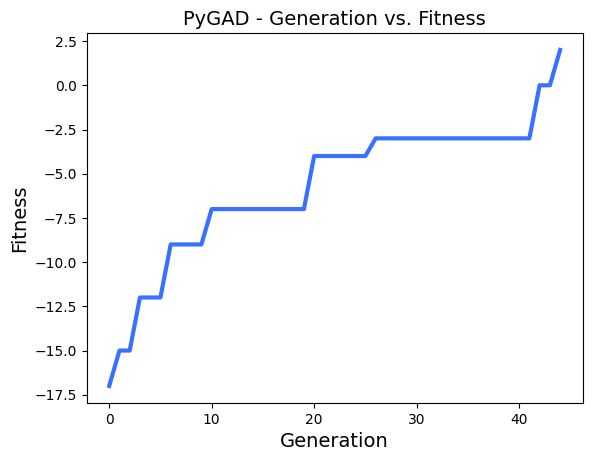

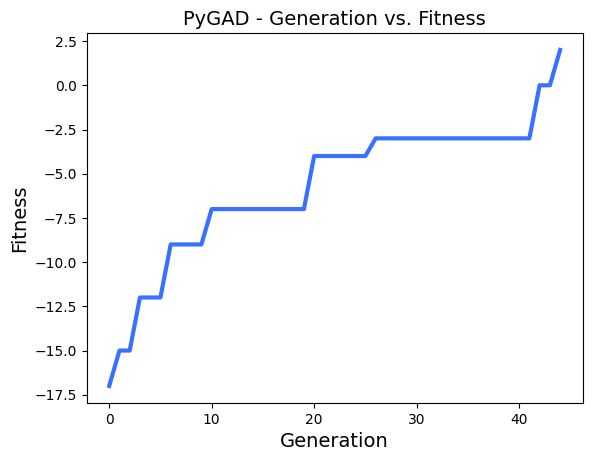

In [99]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [100]:
# najlepsze wyłonione rozwiązanie
r1 = [2, 3, 5, 5, 2, 3]
r2 = [5, 1, 5, 2, 6, 3]
r3 = [1, 2, 2, 6, 3, 1]
r4 = [2, 6, 1, 5, 4, 1]
r5 = [6, 2, 1, 2, 5, 3]
r6 = [1, 5, 6, 4, 1, 2]
tablica = [r1, r2, r3, r4, r5, r6]

for i in range(int(len(solution)/2)):
        tablica[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica

[[0, 3, 5, 0, 2, 0],
 [5, 1, 0, 2, 6, 3],
 [1, 0, 2, 6, 3, 0],
 [2, 6, 0, 5, 4, 1],
 [6, 2, 1, 0, 5, 0],
 [0, 5, 6, 4, 1, 2]]

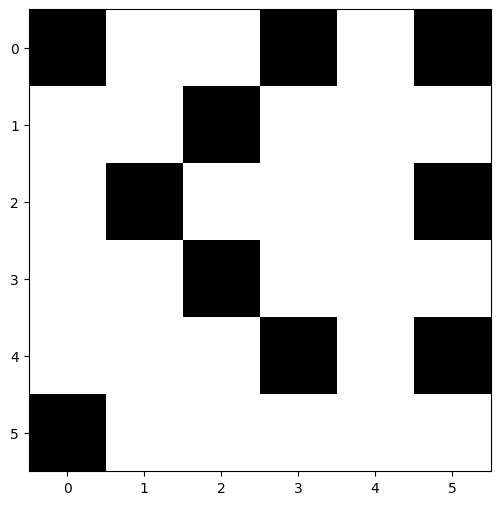

In [101]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

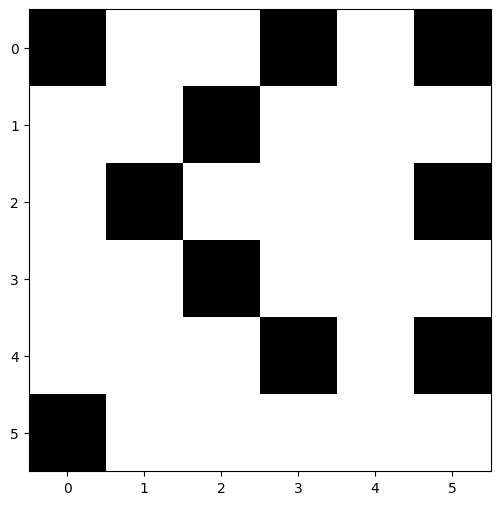

In [102]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 0, 0, 3, 0, 5, 1, 2, 2, 1, 2, 5, 3, 2, 4, 3, 4, 5, 5, 0]
solution = rozwiazanie
tablica3 = [[1 for i in range(6)] for i in range(6)]
for i in range(int(len(solution)/2)):
    tablica3[solution[i*2]][solution[2*i+1]] = 0

plt.figure(figsize=(6, 6))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [103]:
czasy21 = []
licznik21 = 0
for i in range(100):
    r1 = [6, 3, 4, 3, 4, 5]
    r2 = [4, 1, 5, 2, 6, 3]
    r3 = [5, 5, 2, 3, 3, 2]
    r4 = [5, 5, 6, 4, 2, 6]
    r5 = [2, 3, 6, 5, 4, 6]
    r6 = [1, 1, 3, 2, 5, 2]
    t1 = [r1, r2, r3, r4, r5, r6]

    r1 = [6, 5, 6, 3, 5, 2]
    r2 = [1, 4, 4, 5, 3, 6]
    r3 = [2, 3, 5, 1, 1, 1]
    r4 = [6, 1, 3, 4, 6, 5]
    r5 = [5, 4, 6, 4, 2, 3]
    r6 = [4, 5, 3, 2, 5, 3]
    t2 = [r1, r2, r3, r4, r5, r6]

    r1 = [2, 3, 5, 5, 2, 3]
    r2 = [5, 1, 5, 2, 6, 3]
    r3 = [1, 2, 2, 6, 3, 1]
    r4 = [2, 6, 1, 5, 4, 1]
    r5 = [6, 2, 1, 2, 5, 3]
    r6 = [1, 5, 6, 4, 1, 2]
    t3 = [r1, r2, r3, r4, r5, r6]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_2'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 2:
        czasy21.append(czas)
        licznik21 += 1

In [104]:
print('Efektywność: {}%'.format(licznik21))
print('Średni czas wykonania: {}'.format(np.mean(czasy21))) # dla prób z idealnym rozwiązaniem

Efektywność: 92%
Średni czas wykonania: 4.268834748993749


## 7x7

In [105]:
# definiujemy parametry rozwiązania
# dwie kolejne liczby to współrzędne komórki, którą należy zamalować na czarno
gene_space = [0, 1, 2, 3, 4, 5, 6]

# definiujemy funkcję fitness
def fitness_func(solution, solution_idx):
    wynik = 0
    
    # chcemy mieć liczbę zer równą solution/2, więc pary współrzędnych nie mogą się powtarzać
    for i in range(int(len(solution)/2)):
        for j in range(int(len(solution)/2)):
            if i!=j:
                if solution[i*2] == solution[j*2] and solution[i*2+1] == solution[j*2+1]:
                    # jeśli się powtarzają to nakładamy karę
                    wynik -= 1
    
    # warunek, że nie mogą być odizolowane (mają tworzyć poliomino)
    tablica2 = [[1 for _ in range(len(tablica))] for _ in range(len(tablica))]
    for i in range(int(len(solution)/2)):
        tablica2[int(solution[i*2])][int(solution[2*i+1])] = 0
    # współrzędne odwiedzonych komórek dodajemy do listy
    poliomino = []
    # zaczynamy od pierwszej 1
    for i in range(len(tablica2)):
        for j in range(len(tablica2)):
            if int(tablica2[i][j]) == 1:
                poliomino.append([i, j])
                break
        # elementy w liście nie powtarzają się
        if [i, j] in poliomino:
            break
    # przeszukujemy wszerz, aby odwiedzić wszystkie sąsiednie jedynki
    komorka = [[i, j]]
    while komorka:
        wiersz, kolumna = komorka.pop(0)
        for w, k in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            nowy_wiersz = wiersz + w
            nowa_kolumna = kolumna + k
            if 0 <= nowy_wiersz < len(tablica2) and 0 <= nowa_kolumna < len(tablica2):
                if [nowy_wiersz, nowa_kolumna] not in poliomino and tablica2[nowy_wiersz][nowa_kolumna] == 1:
                    poliomino.append([nowy_wiersz, nowa_kolumna])
                    komorka.append([nowy_wiersz, nowa_kolumna])

    # sprawdzamy, czy dotarliśmy do wszystkich jedynek (czy mamy poliomino)
    if len(poliomino) == sum(_.count(1) for _ in tablica2):
        wynik += 2
    if len(poliomino) != sum(_.count(1) for _ in tablica2):
        wynik -= 2
    
    # warunek, że czarne pola nie mogą stykac się bokami
    for m in range(len(tablica)):
        for n in range(len(tablica)-1):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m][n+1]) == 0:
                    wynik -= 1
    for m in range(len(tablica)-1):
        for n in range(len(tablica)):
            if int(tablica2[m][n]) == 0:
                if int(tablica2[m+1][n]) == 0:
                    wynik -= 1
    
    tablica1 = [[0 for _ in range(len(tablica))] for _ in range(len(tablica))]
    # sprawdzamy jak wygląda macierz*solution
    # czyli na łamigłówkę nakładamy czarne pola (zera)
    for i in range(len(tablica)):
        for j in range(len(tablica)):
            tablica1[i][j] = int(tablica[i][j]*tablica2[i][j])

    # warunek, że w kolumnie i wierszu liczby nie mogą się powtarzać
    for i in range(len(tablica1)):
        # jeśli w kolumnie występuje więcej niż jedna taka sama liczba, to nakładamy karę
        kolumna = [_[i] for _ in tablica1]
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        count7 = 0
        for j in kolumna:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
            elif j == 7:
                count7 += 1
        for k in [count1, count2, count3, count4, count5, count6, count7]:
            if k > 1:
                wynik -= 2*k
    for i in range(len(tablica1)):
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        count5 = 0
        count6 = 0
        count7 = 0
        # jeśli we wierszu występuje więcej niż jedna taka sama liczba, to nakładamy karę
        for j in tablica1[i]:
            if j == 1:
                count1 += 1
            elif j == 2:
                count2 += 1
            elif j == 3:
                count3 += 1
            elif j == 4:
                count4 += 1
            elif j == 5:
                count5 += 1
            elif j == 6:
                count6 += 1
            elif j == 7:
                count7 += 1
        for k in [count1, count2, count3, count4, count5, count6, count7]:
            if k > 1:
                wynik -= 2*k
    
    return wynik

fitness_function = fitness_func

In [106]:
num_genes = 28 # powinniśmy zamalować 10 kratek, solution ma 20 genów
mutation_percent_genes = 4 # 28*0.04 czyli 1 gen sie zmieni

### 1)

In [107]:
r1 = [6, 2, 4, 2, 3, 4, 6]
r2 = [6, 5, 6, 1, 7, 4, 3]
r3 = [7, 3, 5, 2, 5, 6, 7]
r4 = [7, 7, 6, 6, 2, 5, 5]
r5 = [2, 6, 3, 5, 2, 7, 4]
r6 = [3, 7, 7, 6, 5, 3, 6]
r7 = [3, 1, 7, 4, 7, 2, 5]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  7.636078596115112
Number of generations passed is : 51
Parameters of the best solution : [4. 4. 3. 6. 5. 6. 0. 3. 0. 0. 5. 0. 2. 4. 3. 3. 0. 5. 2. 0. 5. 2. 6. 4.
 1. 2. 3. 1.]
Fitness value of the best solution = 2


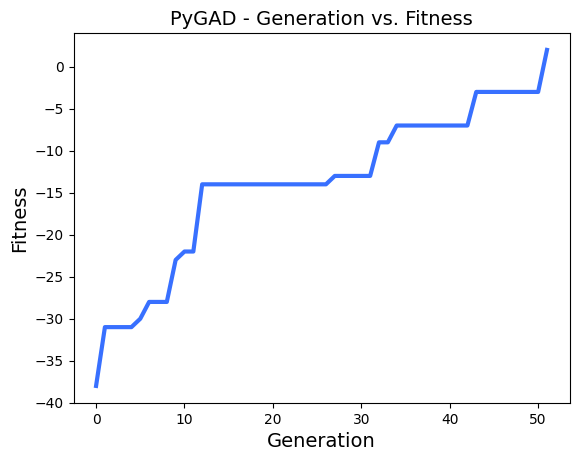

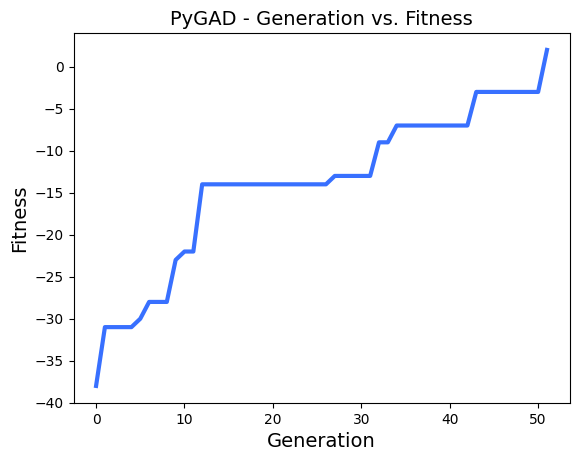

In [108]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [109]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(int(len(solution)/2)):
    tablica4[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica4

[[0, 2, 4, 0, 3, 0, 6],
 [6, 5, 0, 1, 7, 4, 3],
 [0, 3, 5, 2, 0, 6, 7],
 [7, 0, 6, 0, 2, 5, 0],
 [2, 6, 3, 5, 0, 7, 4],
 [0, 7, 0, 6, 5, 3, 0],
 [3, 1, 7, 4, 0, 2, 5]]

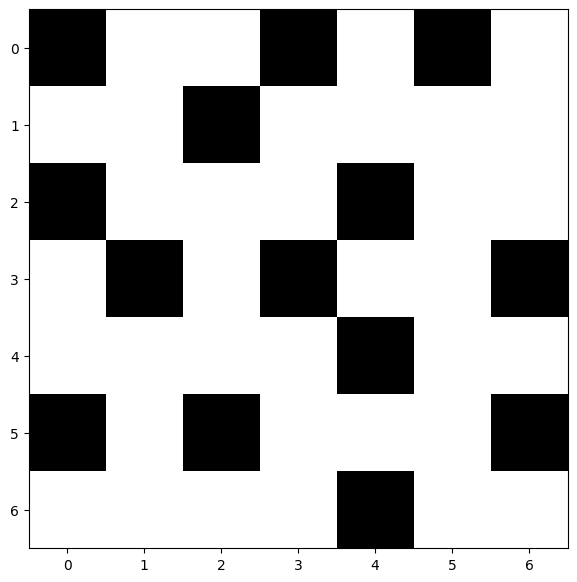

In [110]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

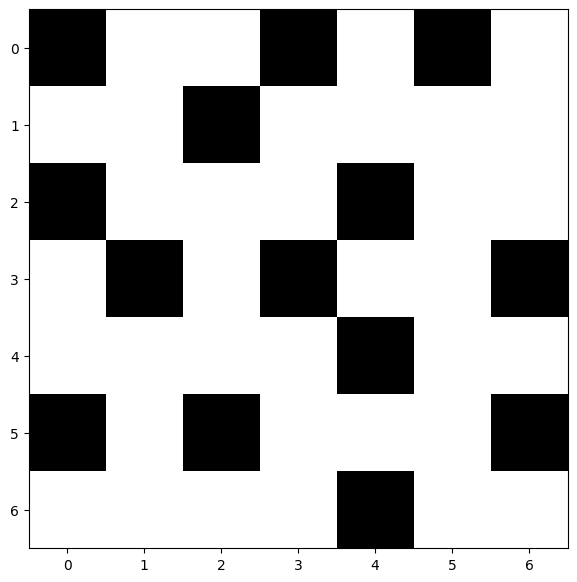

In [111]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 0, 0, 3, 0, 5, 1, 2, 2, 0, 2, 4, 3, 1, 3, 3, 3, 6, 4, 4, 5, 0, 5, 2, 5, 6, 6, 4]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 2)

In [112]:
r1 = [1, 2, 4, 6, 6, 3, 5]
r2 = [3, 4, 4, 3, 2, 2, 1]
r3 = [2, 1, 5, 7, 5, 6, 3]
r4 = [5, 7, 7, 4, 1, 2, 4]
r5 = [5, 7, 3, 4, 5, 3, 4]
r6 = [3, 5, 3, 1, 6, 4, 7]
r7 = [4, 4, 1, 5, 1, 7, 5]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  9.21375322341919
Number of generations passed is : 59
Parameters of the best solution : [6. 6. 6. 4. 4. 5. 3. 6. 3. 1. 4. 0. 1. 0. 6. 1. 1. 2. 0. 4. 5. 2. 4. 3.
 1. 5. 2. 4.]
Fitness value of the best solution = 2


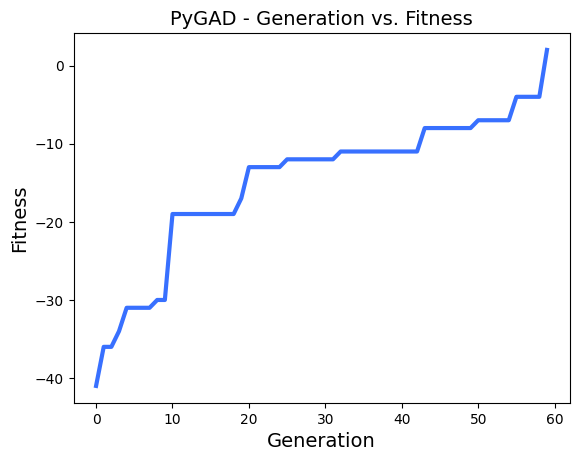

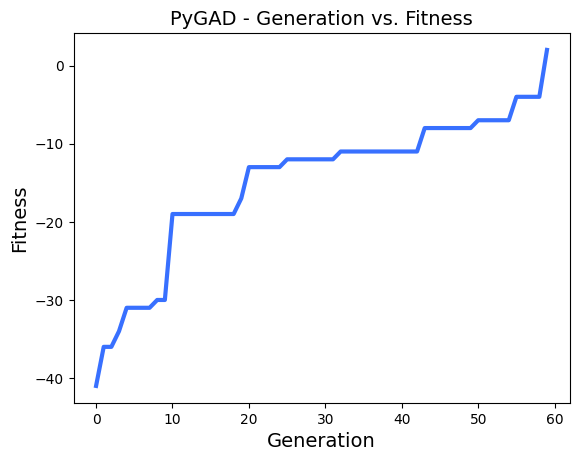

In [113]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [114]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(int(len(solution)/2)):
    tablica4[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica4

[[1, 2, 4, 6, 0, 3, 5],
 [0, 4, 0, 3, 2, 0, 1],
 [2, 1, 5, 7, 0, 6, 3],
 [5, 0, 7, 4, 1, 2, 0],
 [0, 7, 3, 0, 5, 0, 4],
 [3, 5, 0, 1, 6, 4, 7],
 [4, 0, 1, 5, 0, 7, 0]]

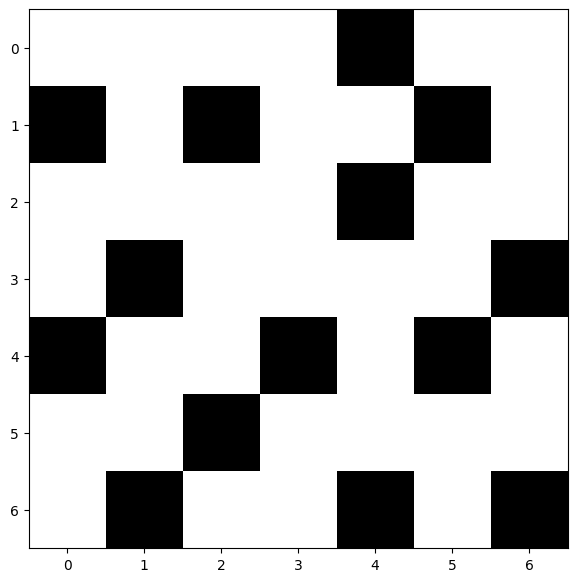

In [115]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

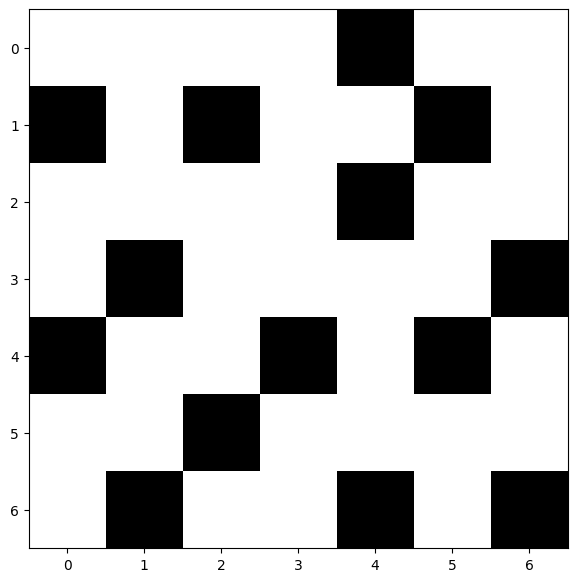

In [116]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 4, 1, 0, 1, 2, 1, 5, 2, 4, 3, 1, 3, 6, 4, 0, 4, 3, 4, 5, 5, 2, 6, 1, 6, 4, 6, 6]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

### 3)

In [117]:
r1 = [5, 6, 1, 2, 5, 7, 7]
r2 = [2, 2, 5, 6, 1, 6, 3]
r3 = [7, 5, 3, 7, 4, 3, 1]
r4 = [4, 3, 7, 7, 2, 5, 3]
r5 = [7, 3, 4, 5, 2, 3, 2]
r6 = [1, 2, 2, 3, 5, 4, 7]
r7 = [4, 4, 2, 6, 1, 1, 2]
tablica = [r1, r2, r3, r4, r5, r6, r7]

start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_elitism=0,
    #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria='reach_2'
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Czas:  9.53917121887207
Number of generations passed is : 60
Parameters of the best solution : [5. 2. 0. 4. 3. 3. 1. 1. 2. 5. 2. 0. 4. 1. 6. 0. 3. 6. 0. 6. 6. 4. 1. 3.
 3. 4. 6. 6.]
Fitness value of the best solution = -3


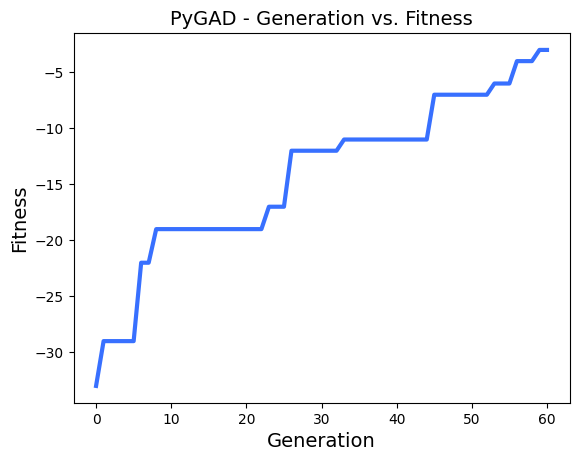

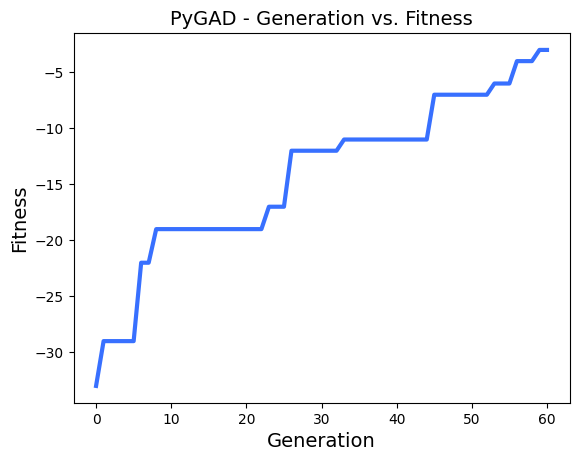

In [118]:
# wyswietlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

In [119]:
# najlepsze wyłonione rozwiązanie
tablica4 = [r1, r2, r3, r4, r5, r6, r7]
for i in range(int(len(solution)/2)):
    tablica4[int(solution[i*2])][int(solution[2*i+1])] = 0
tablica4

[[5, 6, 1, 2, 0, 7, 0],
 [2, 0, 5, 0, 1, 6, 3],
 [0, 5, 3, 7, 4, 0, 1],
 [4, 3, 7, 0, 0, 5, 0],
 [7, 0, 4, 5, 2, 3, 2],
 [1, 2, 0, 3, 5, 4, 7],
 [0, 4, 2, 6, 0, 1, 0]]

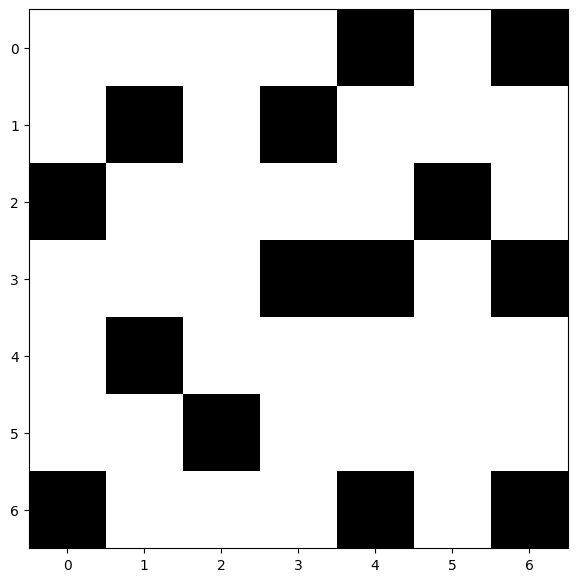

In [120]:
# wykres najlepszego wyłonionego rozwiązania
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

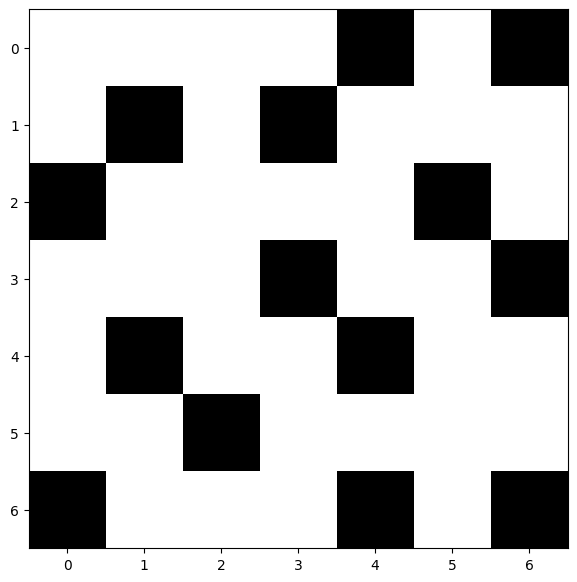

In [121]:
# wykres prawidłowego rozwiązania
rozwiazanie = [0, 4, 0, 6, 1, 1, 1, 3, 2, 0, 2, 5, 3, 3, 3, 6, 4, 1, 4, 4, 5, 2, 6, 0, 6, 4, 6, 6]
solution = rozwiazanie
tablica3 = [[1 for i in range(7)] for i in range(7)]
for i in range(int(len(solution)/2)):
    tablica3[int(solution[i*2])][int(solution[2*i+1])] = 0

plt.figure(figsize=(7, 7))
plt.imshow(tablica3, matplotlib.colormaps.get_cmap('binary_r'))
plt.show()

## Test efektywności algorytmu

In [122]:
czasy31 = []
licznik31 = 0
for i in range(100):
    r1 = [6, 2, 4, 2, 3, 4, 6]
    r2 = [6, 5, 6, 1, 7, 4, 3]
    r3 = [7, 3, 5, 2, 5, 6, 7]
    r4 = [7, 7, 6, 6, 2, 5, 5]
    r5 = [2, 6, 3, 5, 2, 7, 4]
    r6 = [3, 7, 7, 6, 5, 3, 6]
    r7 = [3, 1, 7, 4, 7, 2, 5]
    t1 = [r1, r2, r3, r4, r5, r6, r7]

    r1 = [1, 2, 4, 6, 6, 3, 5]
    r2 = [3, 4, 4, 3, 2, 2, 1]
    r3 = [2, 1, 5, 7, 5, 6, 3]
    r4 = [5, 7, 7, 4, 1, 2, 4]
    r5 = [5, 7, 3, 4, 5, 3, 4]
    r6 = [3, 5, 3, 1, 6, 4, 7]
    r7 = [4, 4, 1, 5, 1, 7, 5]
    t2 = [r1, r2, r3, r4, r5, r6, r7]

    r1 = [5, 6, 1, 2, 5, 7, 7]
    r2 = [2, 2, 5, 6, 1, 6, 3]
    r3 = [7, 5, 3, 7, 4, 3, 1]
    r4 = [4, 3, 7, 7, 2, 5, 3]
    r5 = [7, 3, 4, 5, 2, 3, 2]
    r6 = [1, 2, 2, 3, 5, 4, 7]
    r7 = [4, 4, 2, 6, 1, 1, 2]
    t3 = [r1, r2, r3, r4, r5, r6, r7]
    
    tablica = random.choice([t1, t2, t3])
    
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_elitism=0,
        #keep_parents=keep_parents, # nie może wyjść z maksimum lokalnego
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria='reach_2'
    )
    
    start = time.time()

    # uruchomienie algorytmu
    ga_instance.run()
    
    end = time.time()
    czas = end - start
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    if solution_fitness == 2:
        czasy31.append(czas)
        licznik31 += 1

In [123]:
print('Efektywność: {}%'.format(licznik31))
print('Średni czas wykonania: {}'.format(np.mean(czasy31))) # dla prób z idealnym rozwiązaniem

Efektywność: 56%
Średni czas wykonania: 7.495942980051041


In [124]:
df1 = pd.DataFrame(data=
                  {'Efektywność [%]': [licznik11, licznik21, licznik31],
                   'Średni czas': [np.mean(czasy11), np.mean(czasy21), np.mean(czasy31)]},
                  index=['5x5', '6x6', '7x7'])
df1

,Efektywność [%],Średni czas
5x5,100,1.341350
6x6,92,4.268835
7x7,56,7.495943


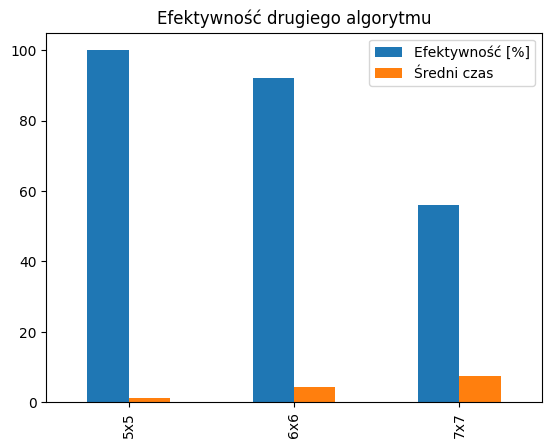

In [125]:
# wykres tabelki
df1.plot.bar()
plt.title('Efektywność drugiego algorytmu')
plt.show()

In [126]:
# Algorytm działa, bardzo dobrze (ponad 50% skuteczności) radzi sobie z różnymi rozmiarami łamigłówek. 
# Czas rozwiązywania też nie jest za długi.

## Wnioski

In [127]:
result = pd.concat([df, df1], keys=["1", "2"])
result

Efektywność [%]  Średni czas
1 5x5               98     2.326380
  6x6               37     5.217688
  7x7               11     7.181069
2 5x5              100     1.341350
  6x6               92     4.268835
  7x7               56     7.495943

In [128]:
# Drugi algorytm jest zdecydowanie bardziej efektywny niż pierwszy. Ponadto jego czasy znajdowania rozwiązań są krótsze.
# (Był przypadek, w którym algorytm pierwszy rozwiązał 1/100 łamigłówek 7x7 i to w czasie 16 sekund.)

# Aby zwiększyć efektywność rozwiązywania większych łamigłówek algorytmem pierwszym, można by zwiększyć wielkość populacji,
# jednak tym samym czas ich rozwiązywania też wzrośnie.
# Zwiększenie ilości pokoleń również może zwiększyć efektywność, ale może być też tak, że przez
# kilkadziesiąt pokoleń nic się nie zmieni, ponieważ funkcja często nie może wyjść z maksimum lokalnego.

## Bibliografia

Informacje:
- https://en.wikipedia.org/wiki/Hitori
- https://www.math.edu.pl/hitori

Zasady gry:
- https://web.archive.org/web/20170812215618/http://www.nikoli.com/en/puzzles/hitori/rule.html

Źródła łamigłówek:
- https://www.brainbashers.com/hitori.asp
- https://www.hitoriconquest.com/

Hitori Solver:
- https://hitori-solver.appspot.com/